In [81]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  3 10:01:23 2020

@author: suraj
"""
# import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from panel_allairfoil import panel

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from keras import backend as kb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

from tensorflow.keras import regularizers

In [82]:
#from helpers import get_lift_drag, preprocess_image, read_csv_file, save_model, load_model

def coeff_determination(y_true, y_pred):
    '''
    custom metric to evaluate the neural network training
    it uses the coefficient of detrmination formula
    for more information : https://en.wikipedia.org/wiki/Coefficient_of_determination
    '''
    SS_res =  kb.sum(kb.square(y_true-y_pred ))
    SS_tot = kb.sum(kb.square( y_true - kb.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + kb.epsilon()) )

def training_data(data,panel_data,aoa,re,lift,drag):
    '''
    Input:
    data ---- this contains the x and y coordinate of airfoil
    panel_data ---- this contains the CL and CD_p determined using the panel method
    aoa ---- angle of attack
    re ---- Reynolds number
    lift ---- lift coefficient from XFoil 
    drag ---- drag coefficient from XFoil
    
    Output:
    xtrain ---- input to the neural network for training (airfoil shape, aoa, re)
    ytrain ---- label of the training dataset (Xfoil lift coefficient)    
    '''
    num_samples = data.shape[0]
    npoints = data.shape[1]
    num_cp = npoints - 1
    nf = data.shape[2]
    xtrain = np.zeros((num_samples,npoints*nf+2))
    ytrain = np.zeros((num_samples,1))
    
    for i in range(num_samples):
        xtrain[i,:npoints] = data[i,:,0]
        xtrain[i,npoints:2*npoints] = data[i,:,1]
        xtrain[i,-2] = aoa[i]
        xtrain[i,-1] = re[i]
        
        ytrain[i,0] = lift[i]
#        ytrain[i,1] = drag[i]
    
    return xtrain, ytrain

def training_data_cp(data,panel_data,aoa,re,lift,drag):
    '''
    Input:
    data ---- this contains the x and y coordinate of airfoil
    panel_data ---- this contains the CL and CD_p determined using the panel method
    aoa ---- angle of attack
    re ---- Reynolds number
    lift ---- lift coefficient from XFoil 
    drag ---- drag coefficient from XFoil
    
    Output:
    xtrain ---- input to the neural network for training 
                (airfoil shape, cp distribution from panel method, aoa, re)
    ytrain ---- label of the training dataset (Xfoil lift coefficient)    
    '''
    num_samples = data.shape[0]
    npoints = data.shape[1]
    num_cp = npoints - 1
    nf = data.shape[2]
    xtrain = np.zeros((num_samples,npoints*nf+num_cp+2))
    ytrain = np.zeros((num_samples,1))
    
    for i in range(num_samples):
        xtrain[i,:npoints] = data[i,:,0]
        xtrain[i,npoints:2*npoints] = data[i,:,1]
        xtrain[i,2*npoints:2*npoints+num_cp] = panel_data[i,2:]
        xtrain[i,-2] = aoa[i]
        xtrain[i,-1] = re[i]
        
        ytrain[i,0] = lift[i]
#        ytrain[i,1] = drag[i]
    
    return xtrain, ytrain

def training_data_cl_cd(data,panel_data,aoa,re,lift,drag):
    '''
    Input:
    data ---- this contains the x and y coordinate of airfoil
    panel_data ---- this contains the CL and CD_p determined using the panel method
    aoa ---- angle of attack
    re ---- Reynolds number
    lift ---- lift coefficient from XFoil 
    drag ---- drag coefficient from XFoil
    
    Output:
    xtrain ---- input to the neural network for training 
                (airfoil shape, CL and CD_p from panel method, aoa, re)
    ytrain ---- label of the training dataset (Xfoil lift coefficient)    
    '''
    num_samples = data.shape[0]
    npoints = data.shape[1]
    num_cp = npoints - 1
    nf = data.shape[2]
    xtrain = np.zeros((num_samples,npoints*nf+2+2))
    ytrain = np.zeros((num_samples,1))
    
    for i in range(num_samples):
        xtrain[i,:npoints] = data[i,:,0]
        xtrain[i,npoints:2*npoints] = data[i,:,1]
        xtrain[i,-4] = panel_data[i,0]
        xtrain[i,-3] = panel_data[i,1]
        xtrain[i,-2] = aoa[i]
        xtrain[i,-1] = re[i]
        
        ytrain[i,0] = lift[i]
#        ytrain[i,1] = drag[i]
    
    return xtrain, ytrain

def training_data_cl(data,panel_data,aoa,re,lift,drag):
    '''
    Input:
    data ---- this contains the x and y coordinate of airfoil
    panel_data ---- this contains the CL and CD_p determined using the panel method
    aoa ---- angle of attack
    re ---- Reynolds number
    lift ---- lift coefficient from XFoil 
    drag ---- drag coefficient from XFoil
    
    Output:
    xtrain ---- input to the neural network for training 
                (airfoil shape, CL from panel method, aoa, re)
    ytrain ---- label of the training dataset (Xfoil lift coefficient)    
    '''
    num_samples = data.shape[0]
    npoints = data.shape[1]
    num_cp = npoints - 1
    nf = data.shape[2]
    xtrain = np.zeros((num_samples,npoints*nf+2+1))
    ytrain = np.zeros((num_samples,1))
    
    for i in range(num_samples):
        xtrain[i,:npoints] = data[i,:,0]
        xtrain[i,npoints:2*npoints] = data[i,:,1]
        xtrain[i,-3] = panel_data[i,0]
        xtrain[i,-2] = aoa[i]
        xtrain[i,-1] = re[i]
        
        ytrain[i,0] = lift[i]
#        ytrain[i,1] = drag[i]
    
    return xtrain, ytrain

In [83]:
# selct the model for training
im = 2 # 1: (x,y), 2: (x,y,cl,cd), 3: (x,y,Cp) 4: (x,y,cl)

# define path/ folder which contains airfoil shape in csv format
data_path = r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\airfoil_shapes_re_v2'

# number of cordinates defining the airfoil shape
num_xy = 201
num_cp = num_xy - 1

# train_data.csv file contains airfoil cordinates, aos, re, and CL, CD determined from XFoil 
# the folder airfoil_shapes_re_v2 contains some python files that generates the data
# airfoil_shape_generator.py : script for generating airfoil shape (x, y cordinates)
# merge_files.py : for merginf all airfoil shapes in a single file
# xfoil_analysis_v2.py: Ffor analyzing airfoils and generating CL, CD data using XFoil module in python

# read the data from train_data.csv file
df = pd.read_csv(r"C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\airfoil_shapes_re_v2\train_data.csv", encoding='utf-8')

col_name = []
col_name.append('Airfoil')
for i in range(num_xy):
    col_name.append(f'x{i}')
for i in range(num_xy):
    col_name.append(f'y{i}')
    
col_name.append('AOA1')    
col_name.append('AOA2')
col_name.append('RE')
col_name.append('CL')
col_name.append('CD')
col_name.append('CM')
col_name.append('CPmin')

df.columns = col_name

df = df[df['CL'].notna()]

num_samples = df.shape[0]

panel_data = np.zeros((num_samples,num_cp+2))
data_xy = np.zeros((num_samples,num_xy,2))

airfoil_names = []
aoa = np.zeros(num_samples)
re = np.zeros(num_samples)
cl = np.zeros(num_samples)
cd = np.zeros(num_samples)
cm = np.zeros(num_samples)


airfoils_xcoords = df.iloc[:,1:202].values
airfoils_ycoords = df.iloc[:,202:403].values

params = df.iloc[:,403:].values

In [84]:
# generate and save the required data for training 
# (i.e, the variables required for creating xtrain and ytrain)
counter = 0
cd_scale_factor = 10.0

generate_new_train_data = False

if generate_new_train_data:
    for index, row in df.iterrows():
        airfoil_names.append(row.Airfoil)
        aoa[counter] = row.AOA2
        re[counter] = row.RE
        cl[counter] = row.CL
        cd[counter] = row.CD*cd_scale_factor
        cm[counter] = row.CM
        
        data_xy[counter,:,0] = airfoils_xcoords[counter,:]
        data_xy[counter,:,1] = airfoils_ycoords[counter,:]
        
        CL, CDP, Cp, pp = panel(data_xy[counter,:,:], alfader=row.AOA2)
        panel_data[counter,0], panel_data[counter,1], panel_data[counter,2:] = CL,CDP, Cp
        
        print(counter, row.Airfoil, row.AOA2, row.RE)
        counter +=1

    aa,bb = np.where(panel_data < -35)
    aau = np.unique(aa)
    
    aoa = np.delete(aoa, aau, axis=0)
    re = np.delete(re, aau, axis=0)
    cl = np.delete(cl, aau, axis=0)
    cd = np.delete(cd, aau, axis=0)
    cm = np.delete(cm, aau, axis=0)
    
    data_xy = np.delete(data_xy, aau, axis=0)
    panel_data = np.delete(panel_data, aau, axis=0)
    
    num_samples = panel_data.shape[0]
    
    np.savez('train_data_re.npz', data_xy=data_xy, panel_data=panel_data, aoa=aoa, re=re, cl=cl, cd=cd, cm=cm)



else:
    # db2 = dir_name + data_path + 'train_data_re.npz'
    data = np.load(r"C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\train_data_re.npz")
    data_xy = data['data_xy']
    panel_data = data['panel_data']
    aoa = data['aoa']
    re = data['re']
    cl = data['cl']
    cd = data['cd']
    cm = data['cm']

In [85]:
# generate xtrain and ytrain for training the neural network
if im == 1:       
    xtrain, ytrain = training_data(data_xy,panel_data,aoa,re,cl,cd)
elif im == 2:       
    xtrain, ytrain = training_data_cl_cd(data_xy,panel_data,aoa,re,cl,cd)
elif im == 3:       
    xtrain, ytrain = training_data_cp(data_xy,panel_data,aoa,re,cl,cd)
elif im == 4:       
    xtrain, ytrain = training_data_cl(data_xy,panel_data,aoa,re,cl,cd)
    

#! scale the input and output data between the range [-1, 1]
sc_input = MinMaxScaler(feature_range=(-1,1))
sc_input = sc_input.fit(xtrain)
xtrain_sc = sc_input.transform(xtrain)

sc_output = MinMaxScaler(feature_range=(-1,1))
sc_output = sc_output.fit(ytrain)
ytrain_sc = sc_output.transform(ytrain)

xtrain, ytrain = xtrain_sc, ytrain_sc

# only shape of the airfoil (x and y cordinates)
xtrain1 = np.copy(xtrain[:,:2*num_xy])

# aoa, re, and physics-based features from panel method
xtrain2 = np.copy(xtrain[:,2*num_xy:])

#%%
training = True
nf1 = xtrain1.shape[1] # number of features related to airfoil shape
nf2 = xtrain2.shape[1] # number of physics-based features related to flow
nl = ytrain.shape[1] # number of labels (1 in POF paper, as we predict only lift coefficient)

10
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 402)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           8060        ['input_29[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 20)           420         ['dense[0][0]']                  
                                                                                                  
 input_30 (InputLayer)          [(None, 4)]          0           []                               
                                                                                           

C:\Users\emjan\AppData\Local\Temp\ipykernel_4800\3746297121.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


220
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_71 (InputLayer)          [(None, 402)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           8060        ['input_71[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 20)           420         ['dense[0][0]']                  
                                                                                                  
 input_72 (InputLayer)          [(None, 4)]          0           []                               
                                                                                          

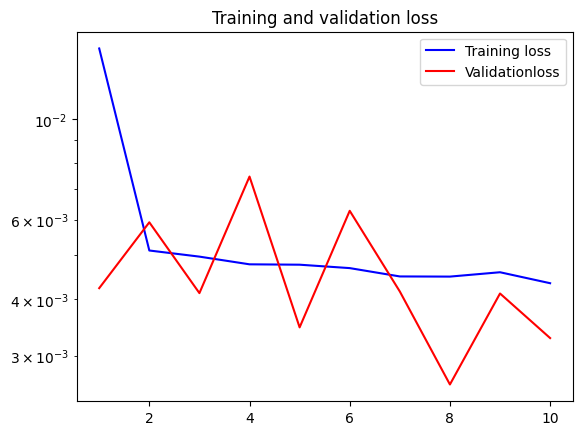

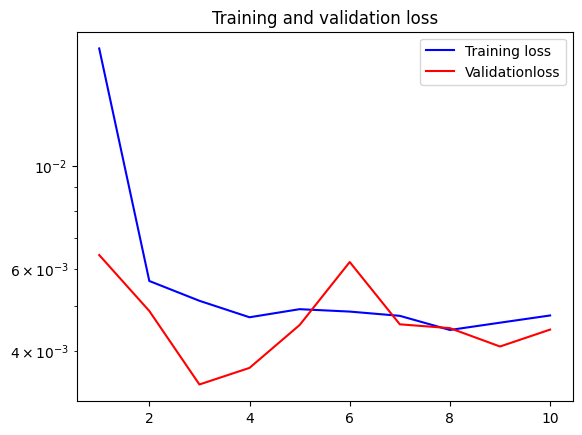

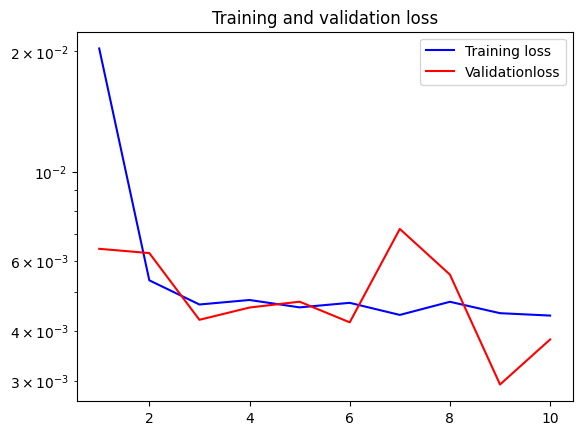

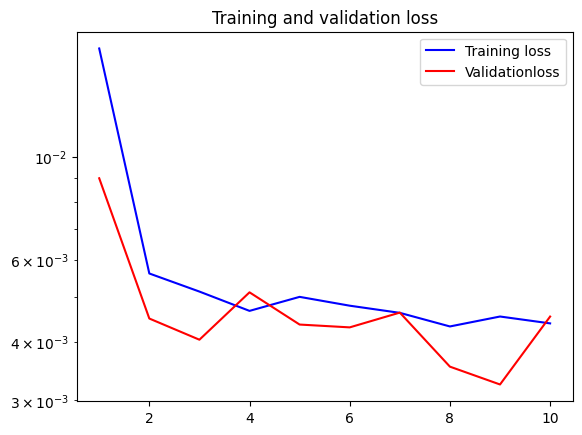

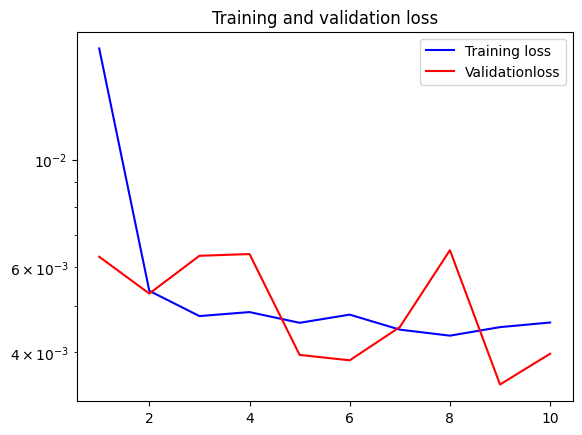

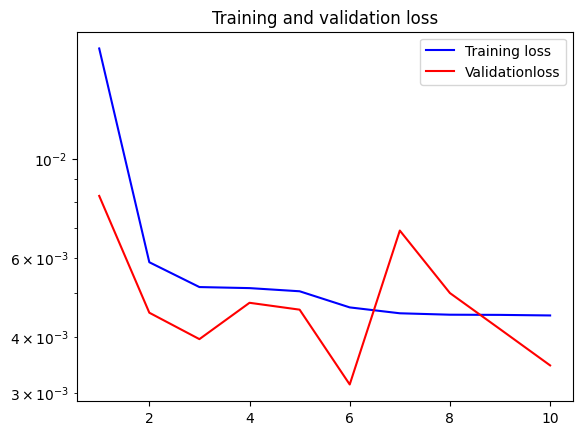

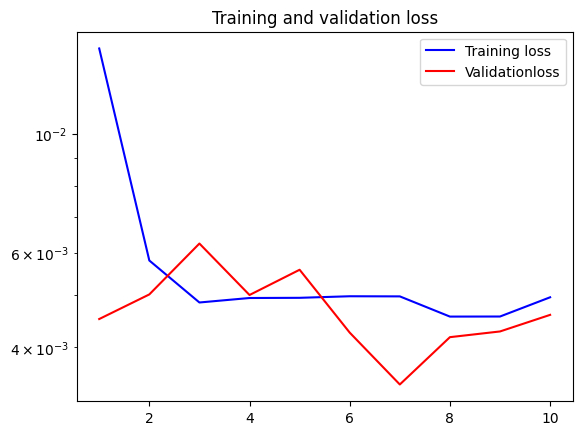

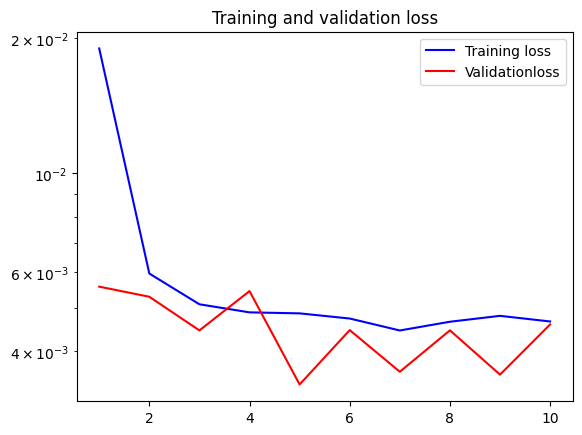

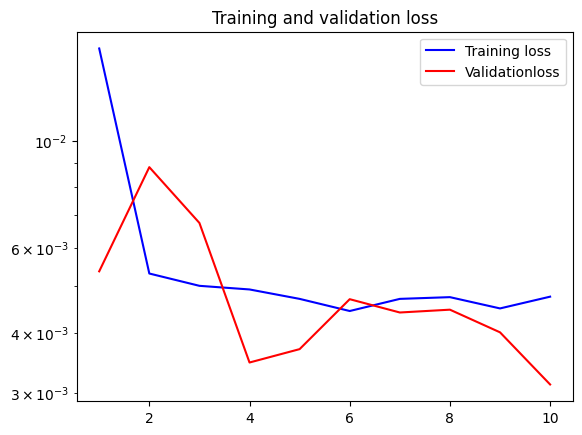

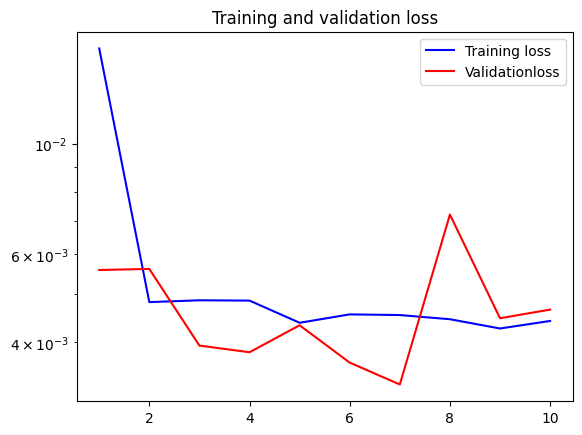

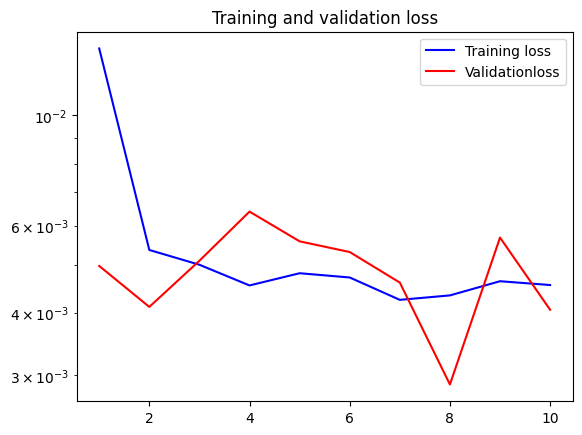

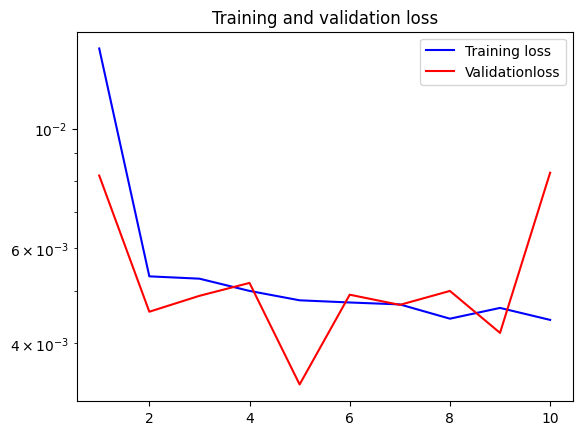

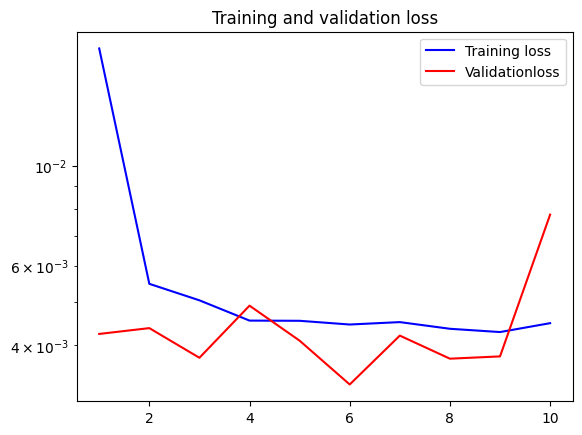

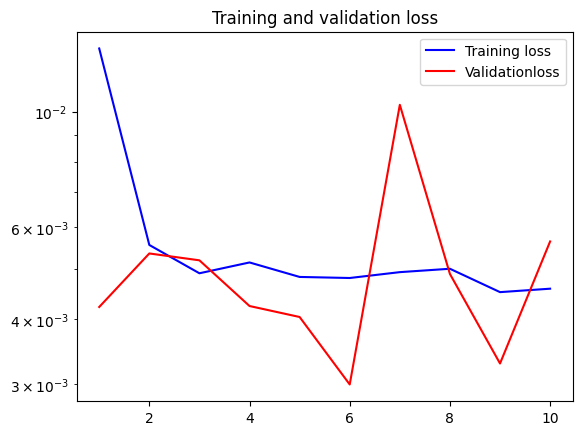

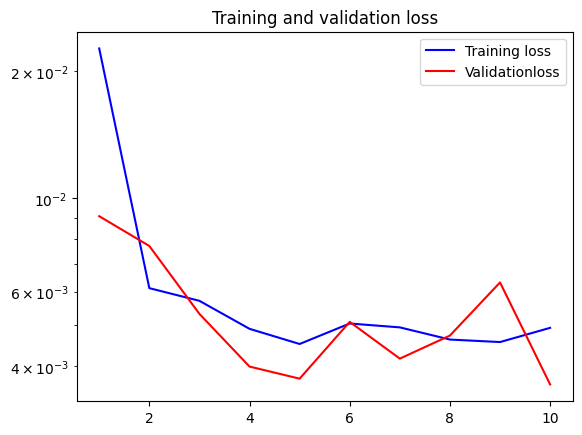

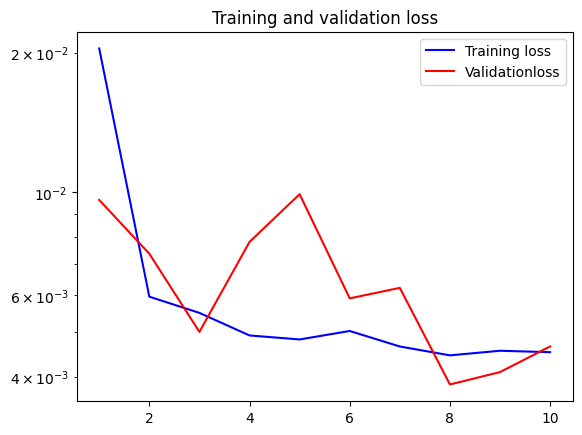

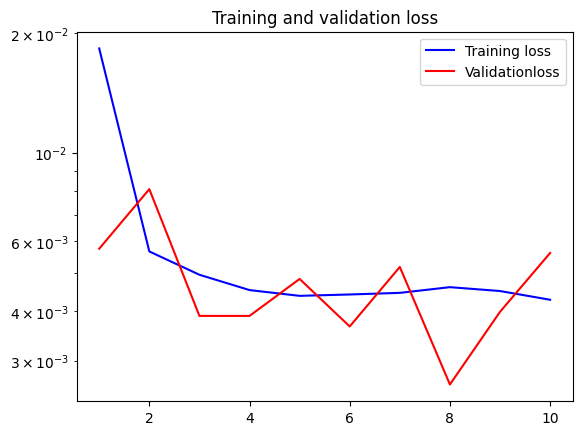

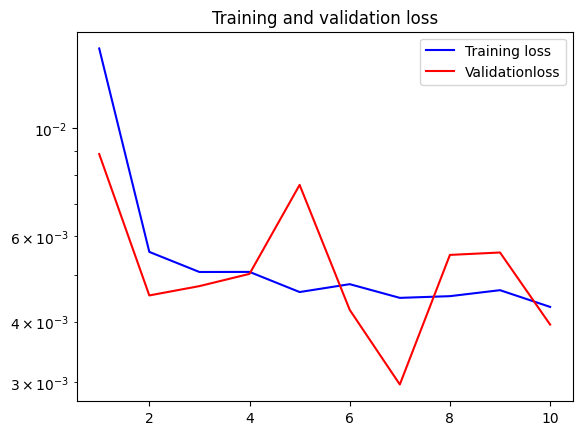

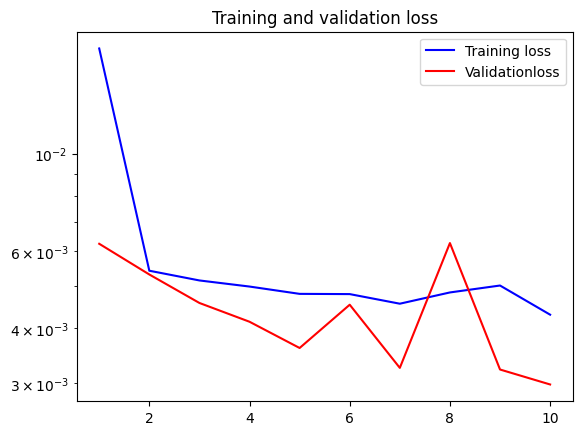

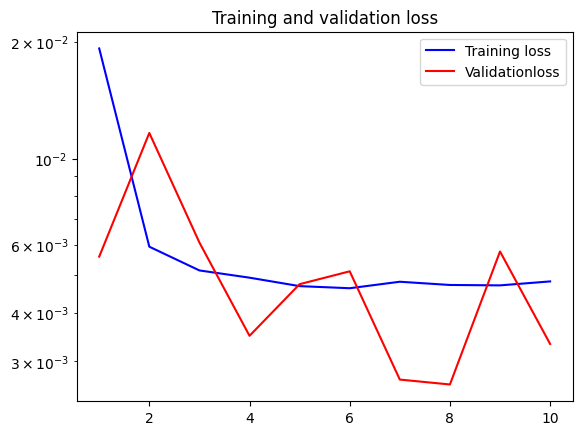

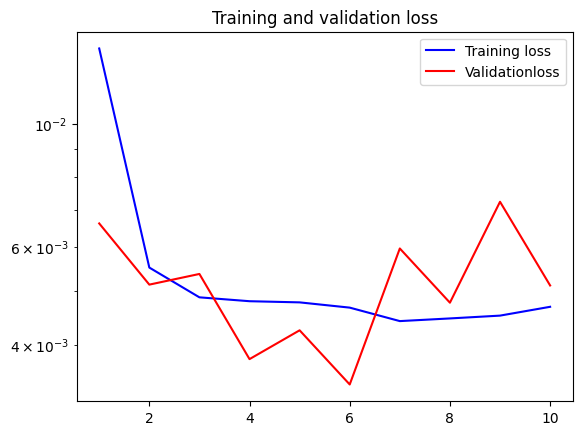

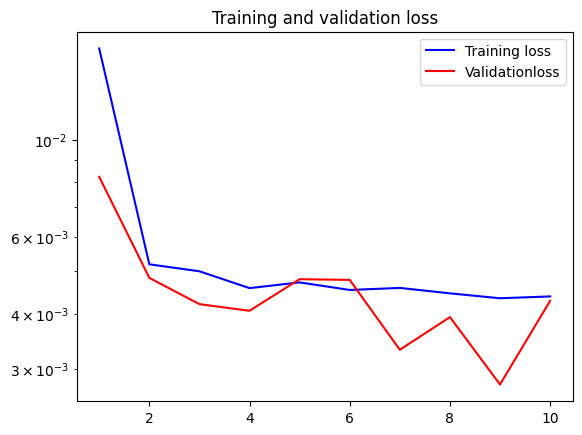

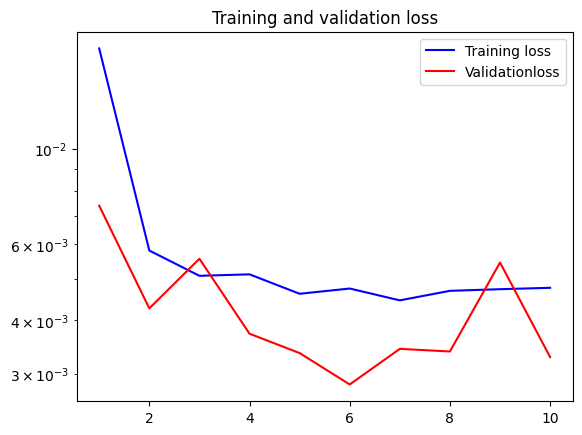

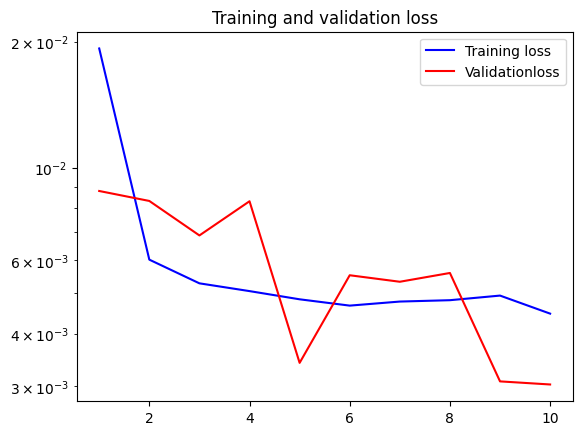

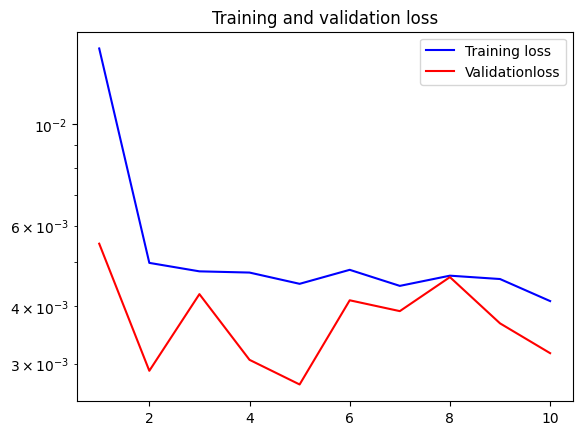

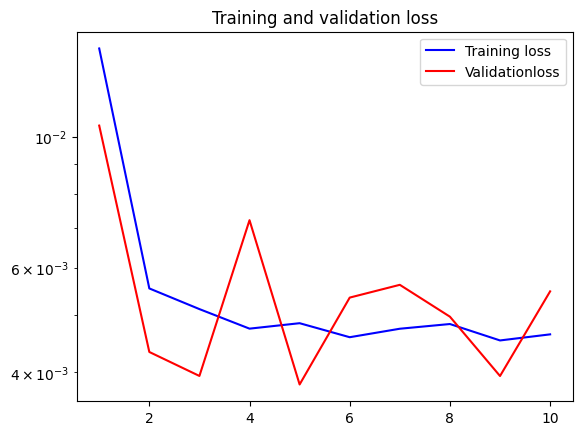

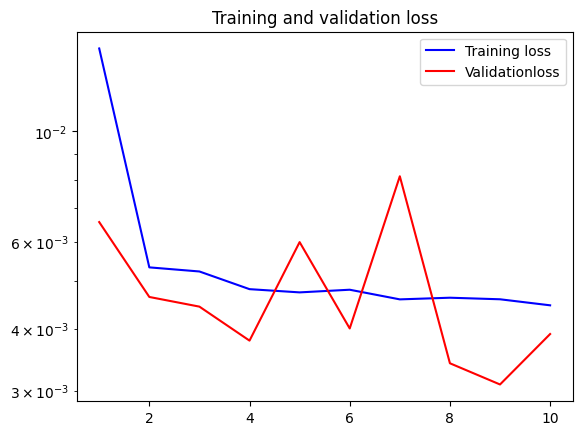

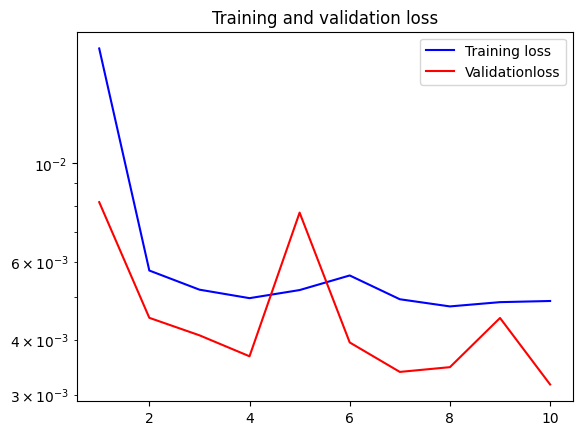

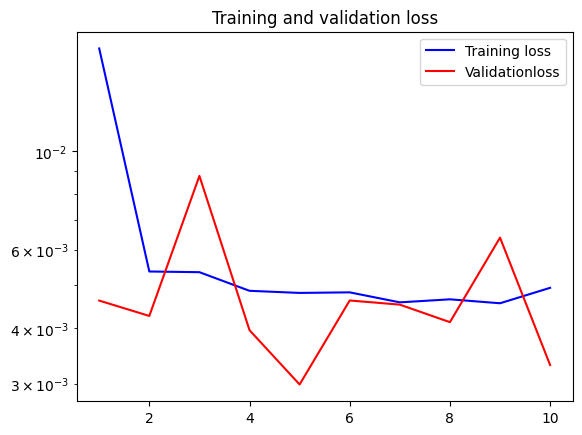

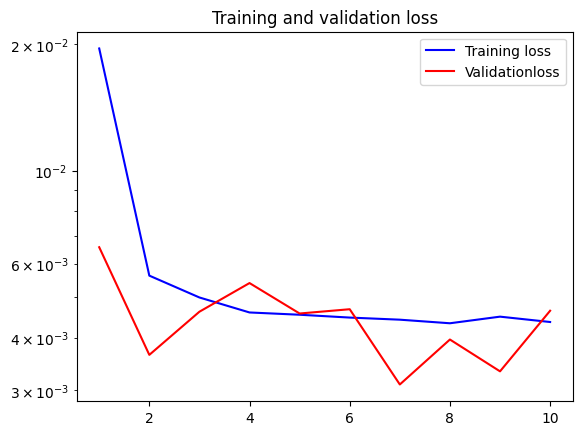

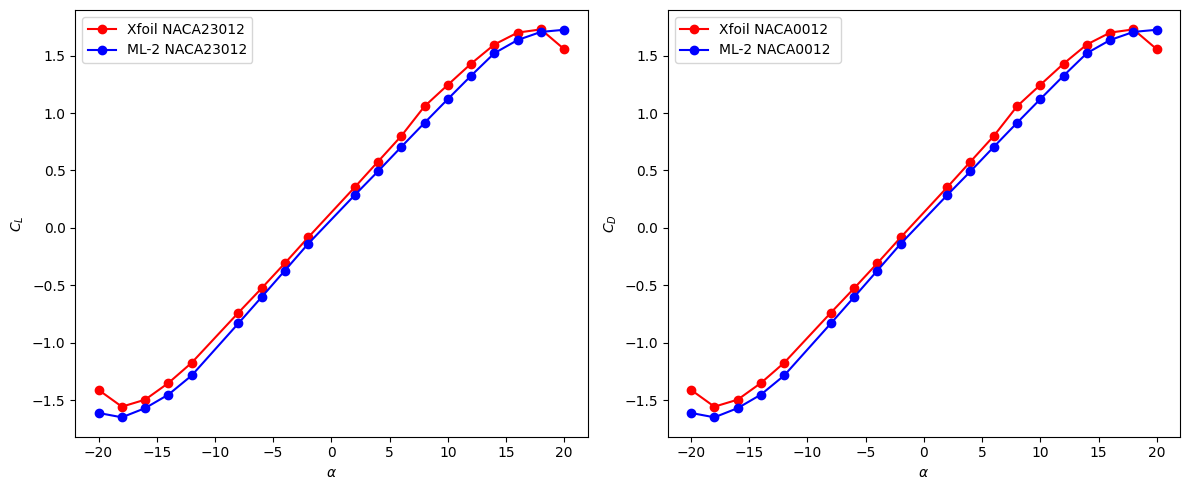

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

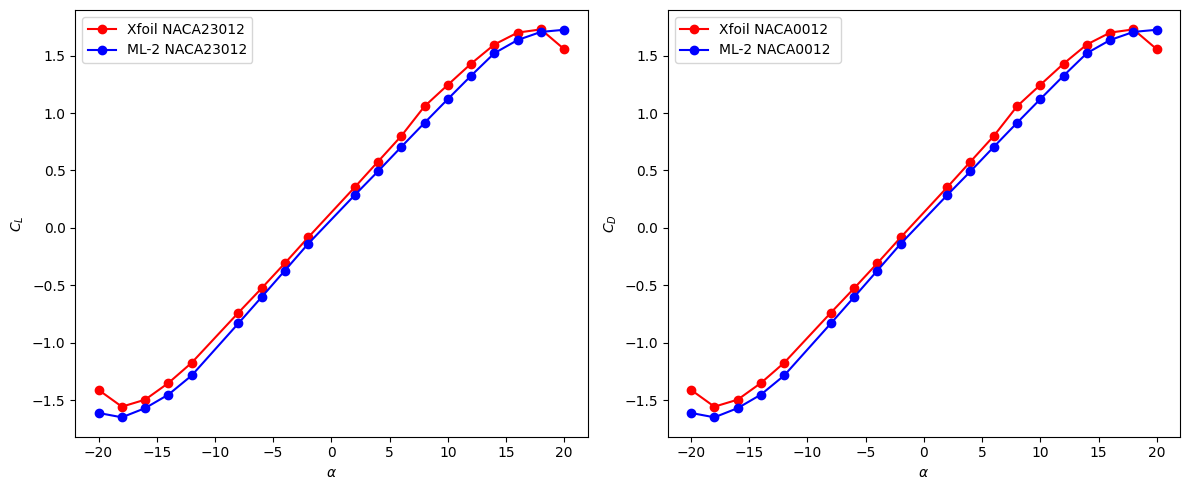

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

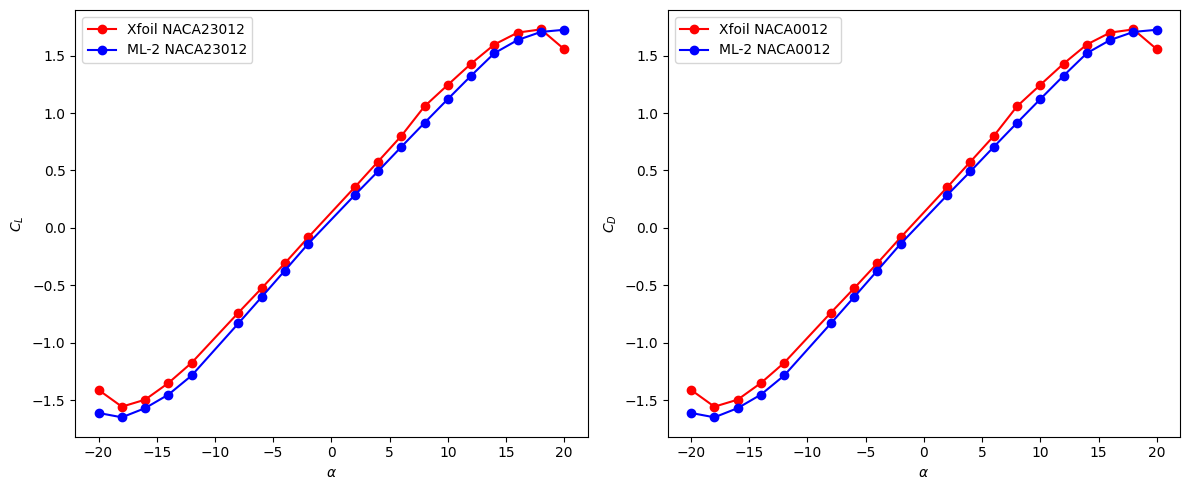

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

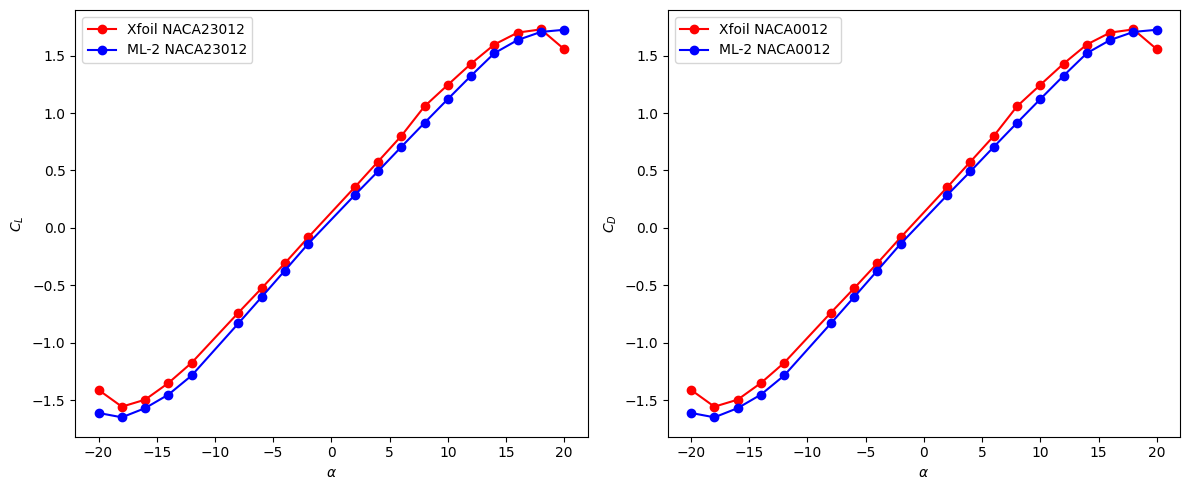

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

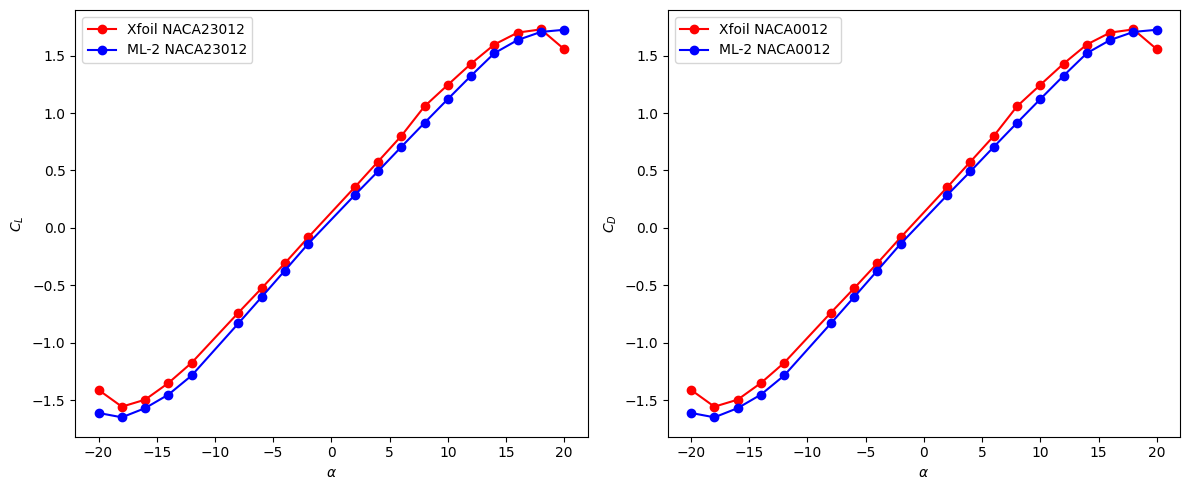

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

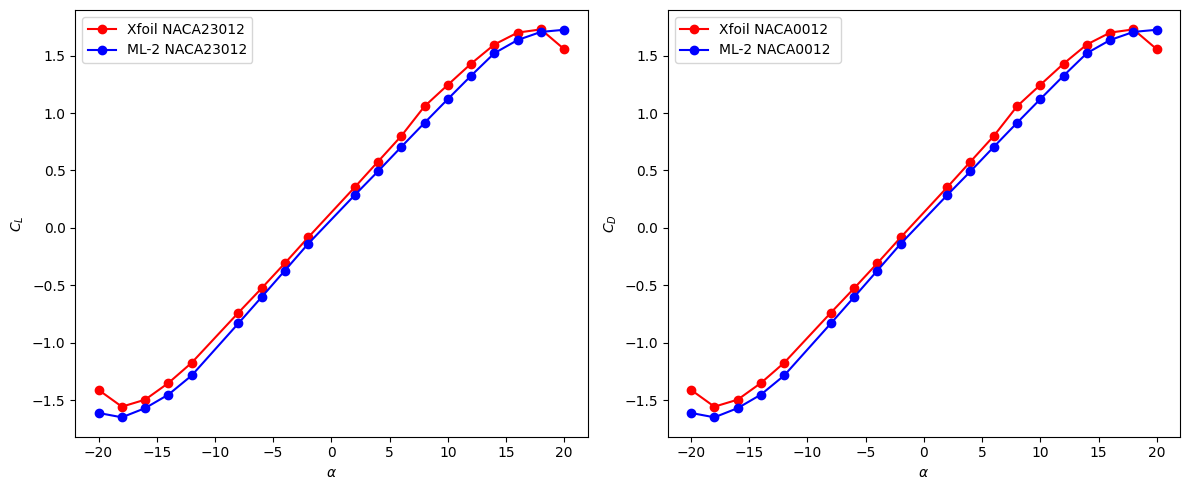

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

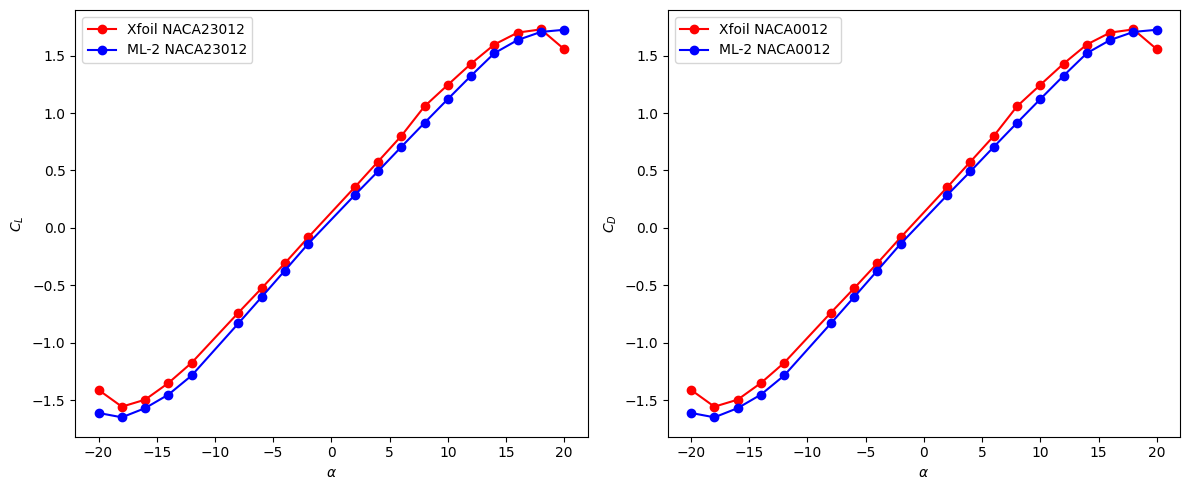

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

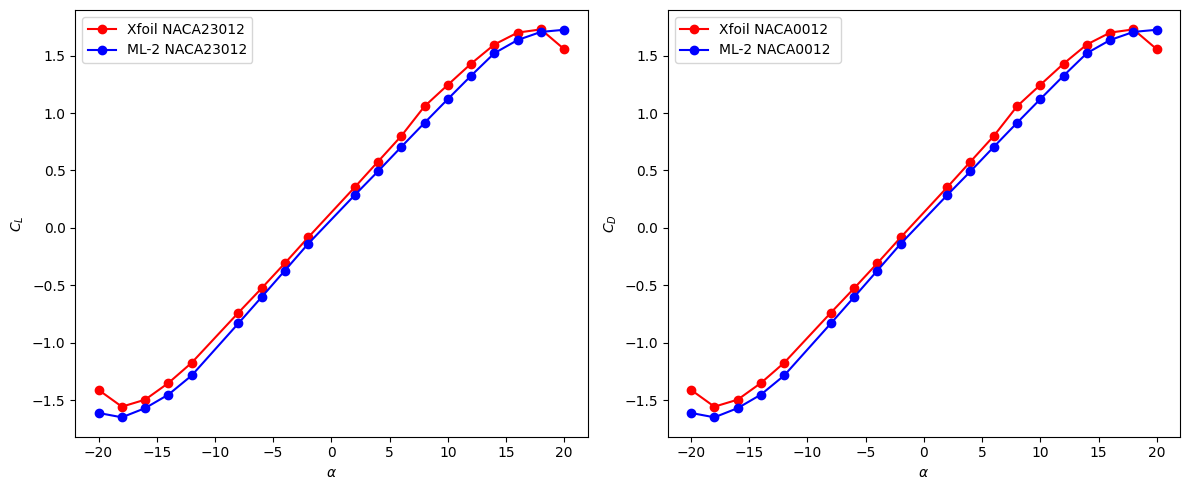

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

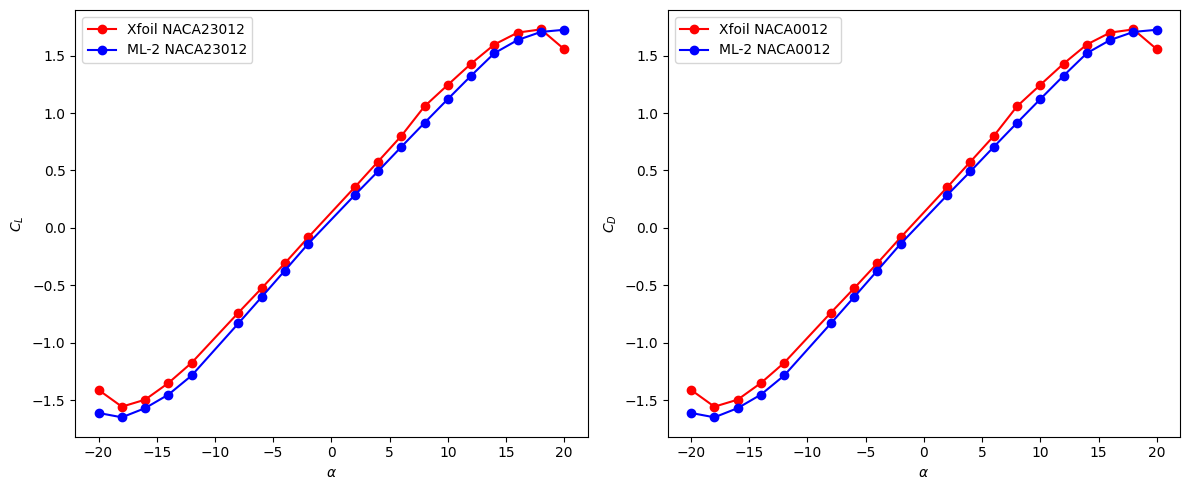

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

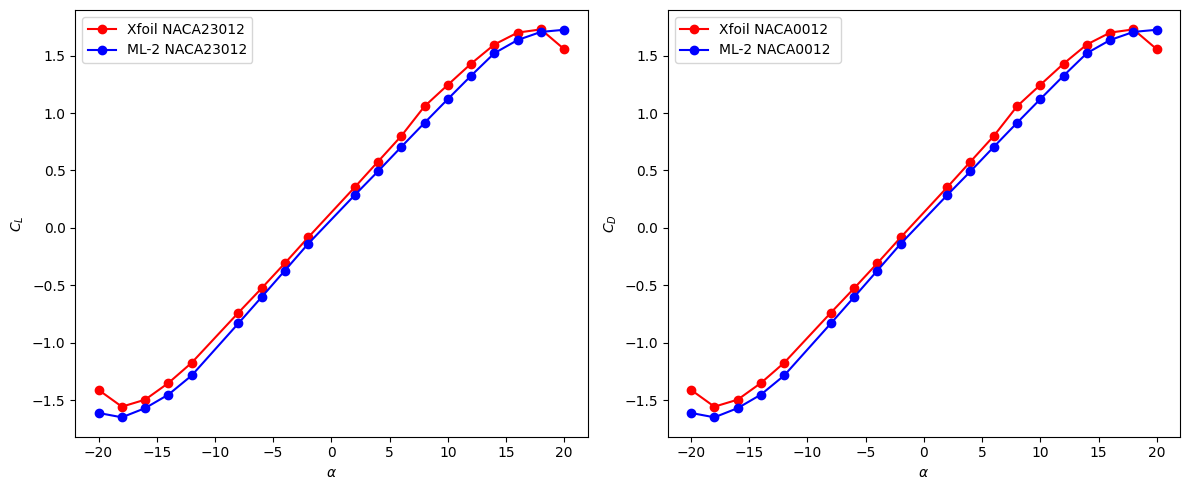

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

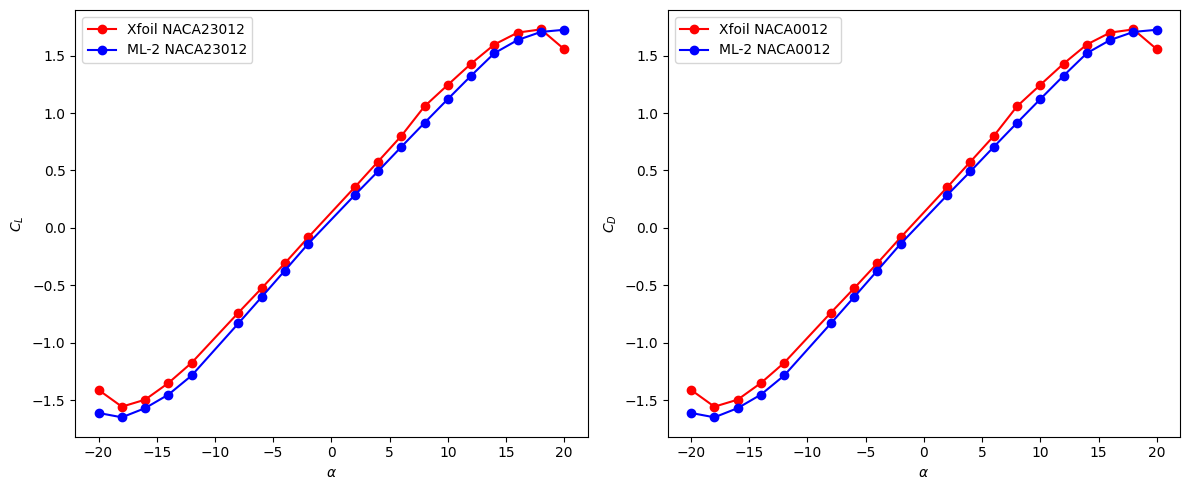

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

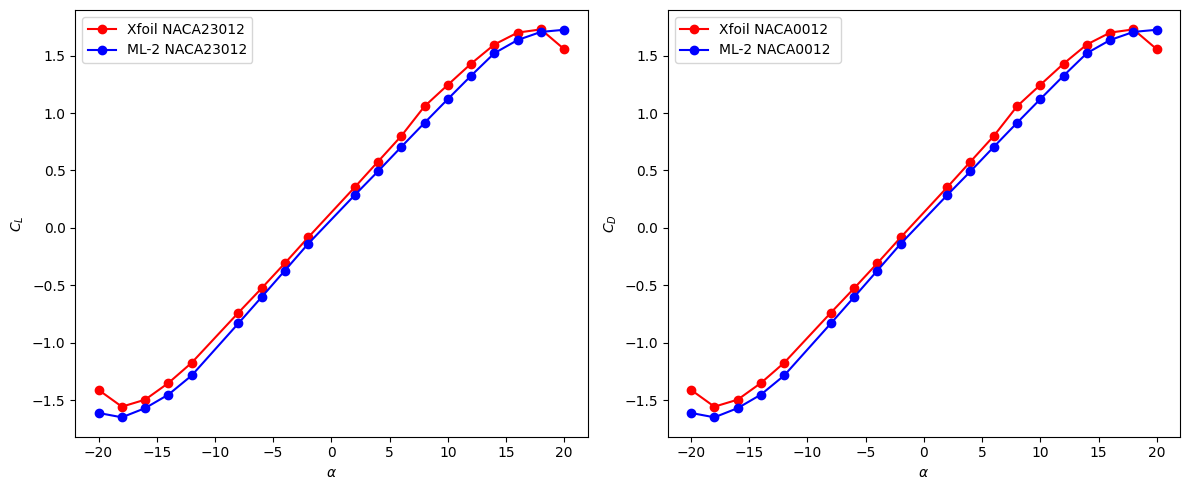

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

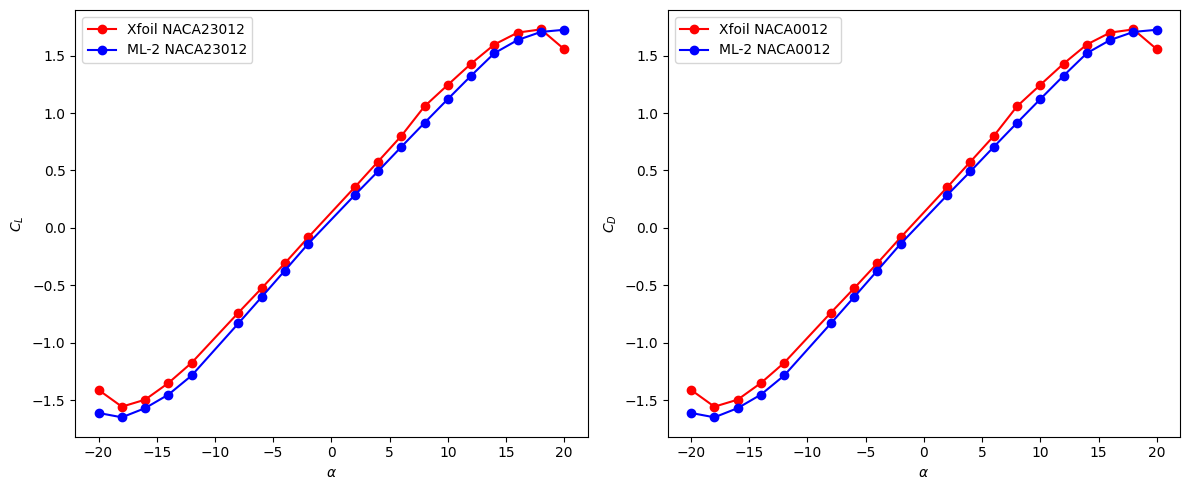

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

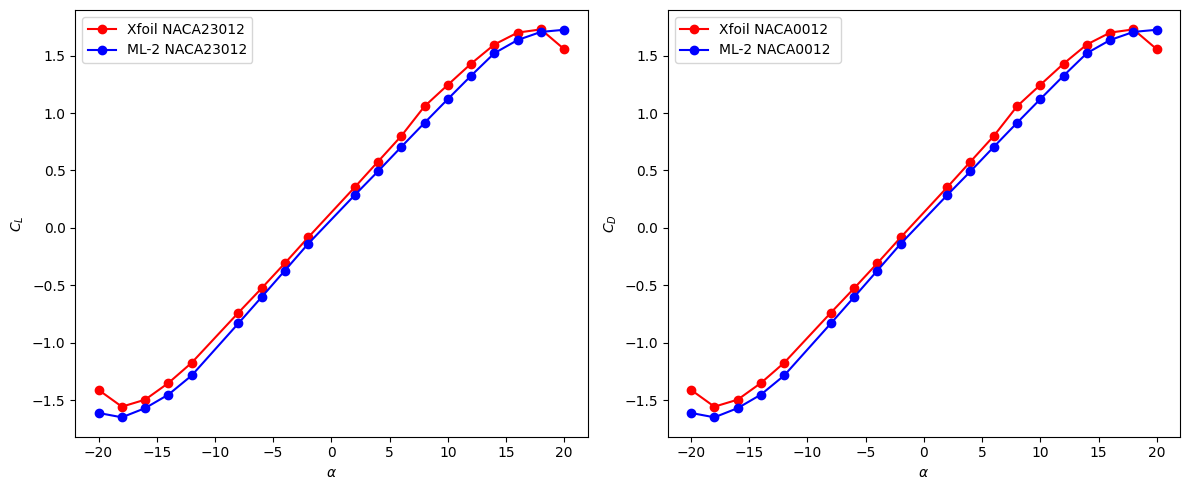

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

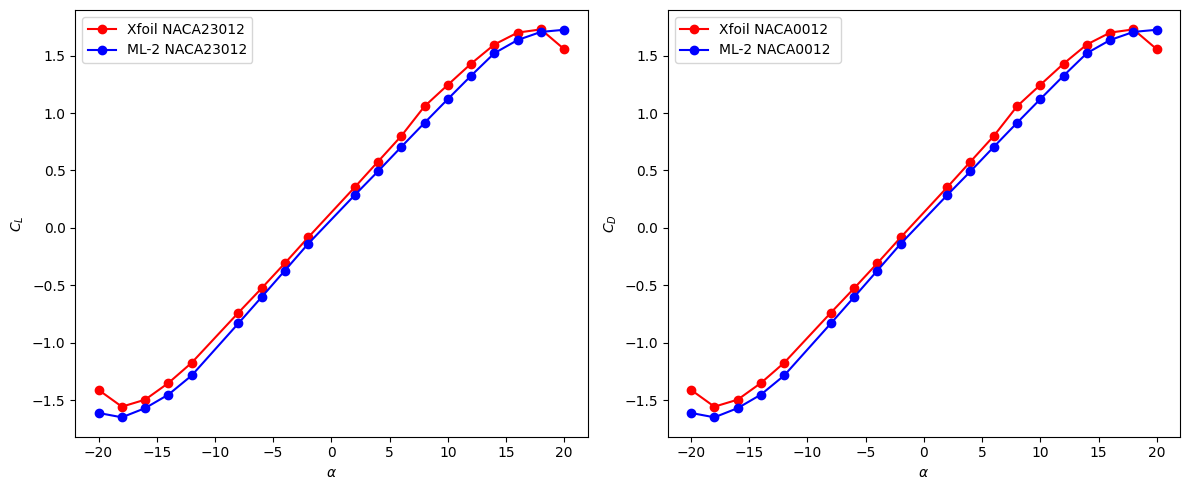

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

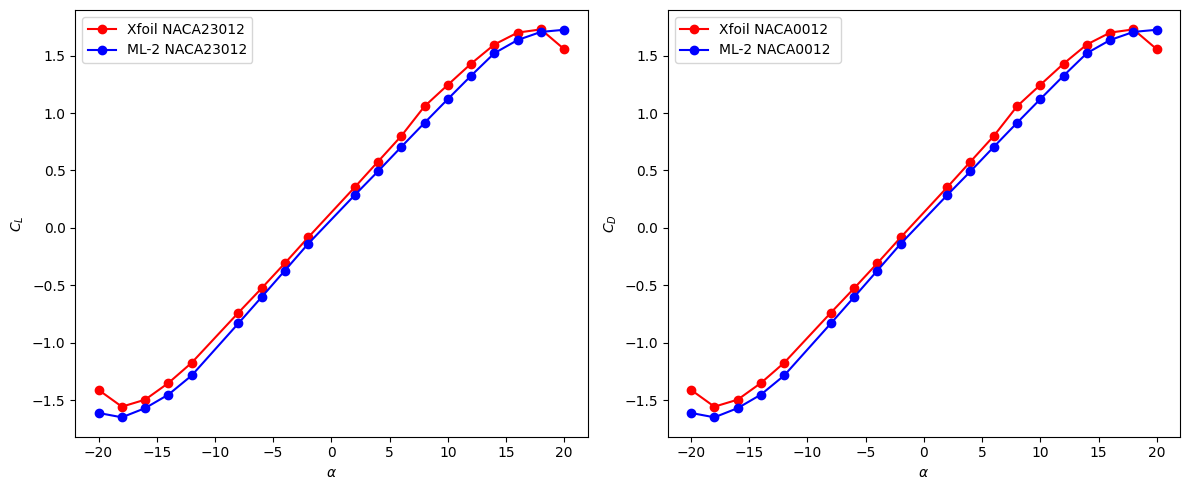

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

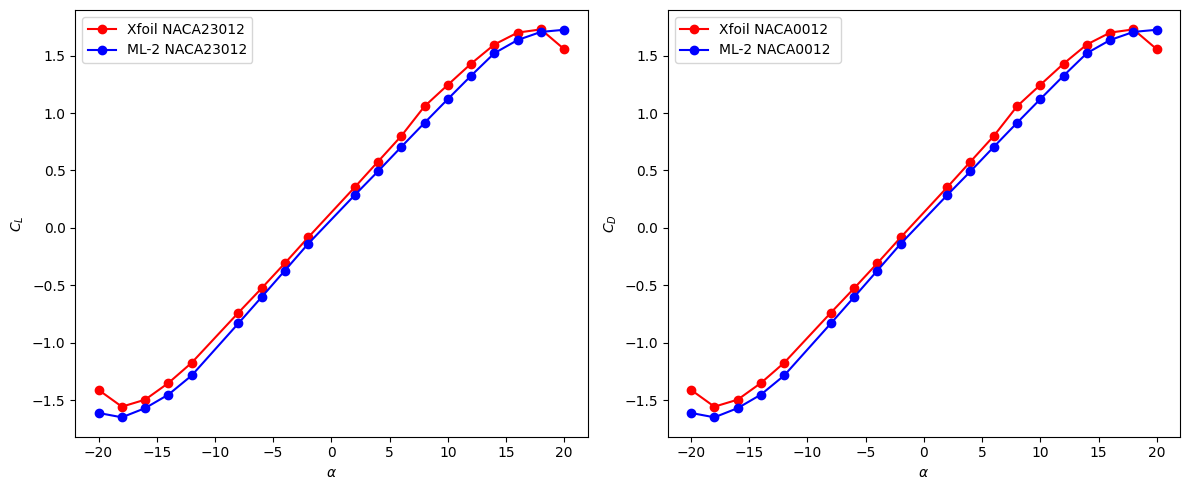

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

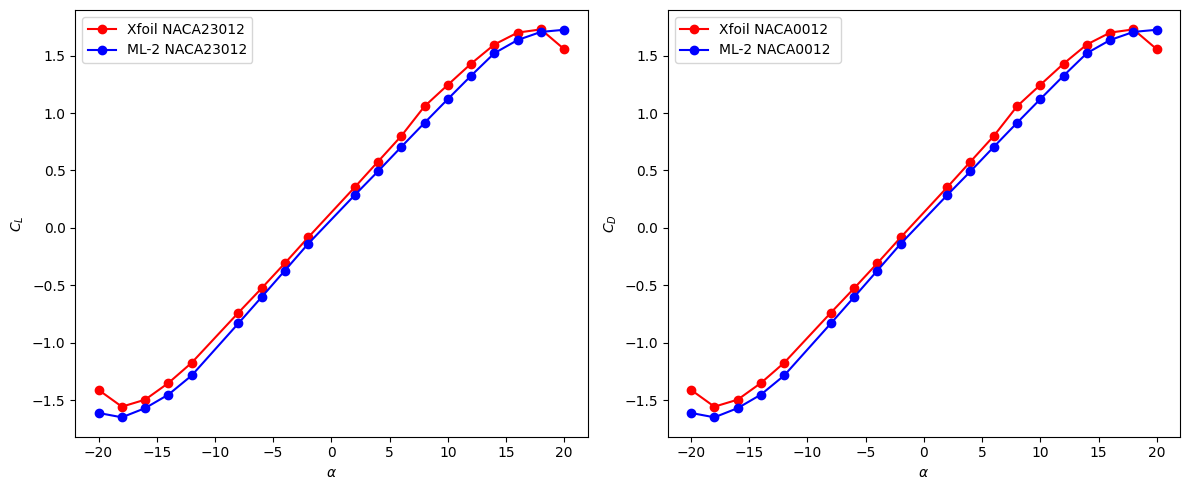

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

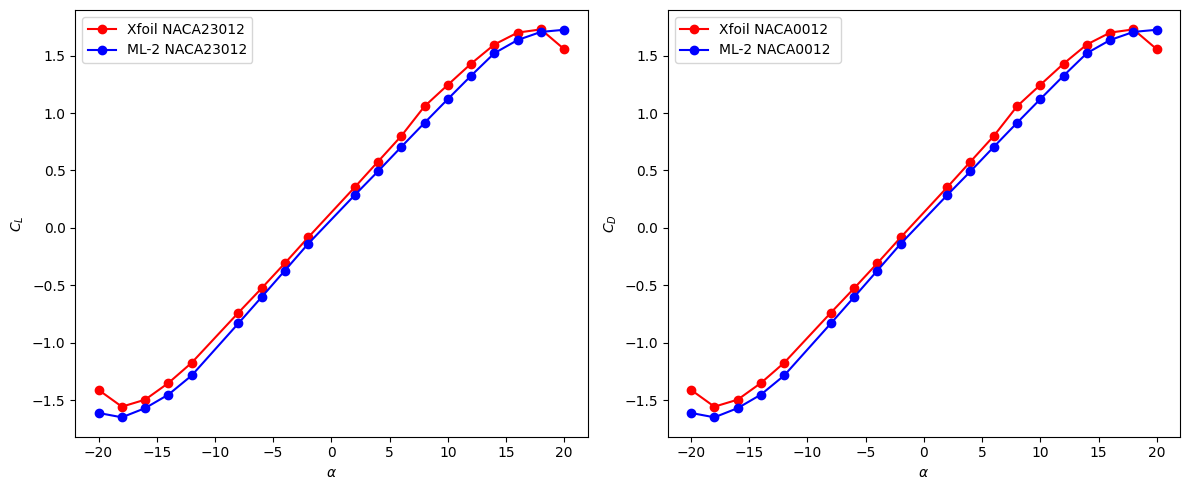

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

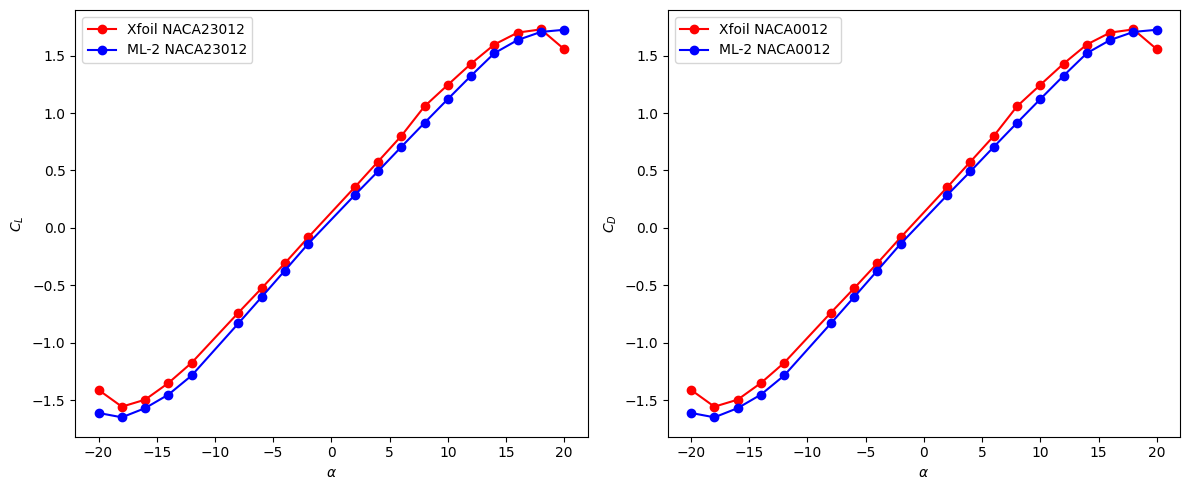

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

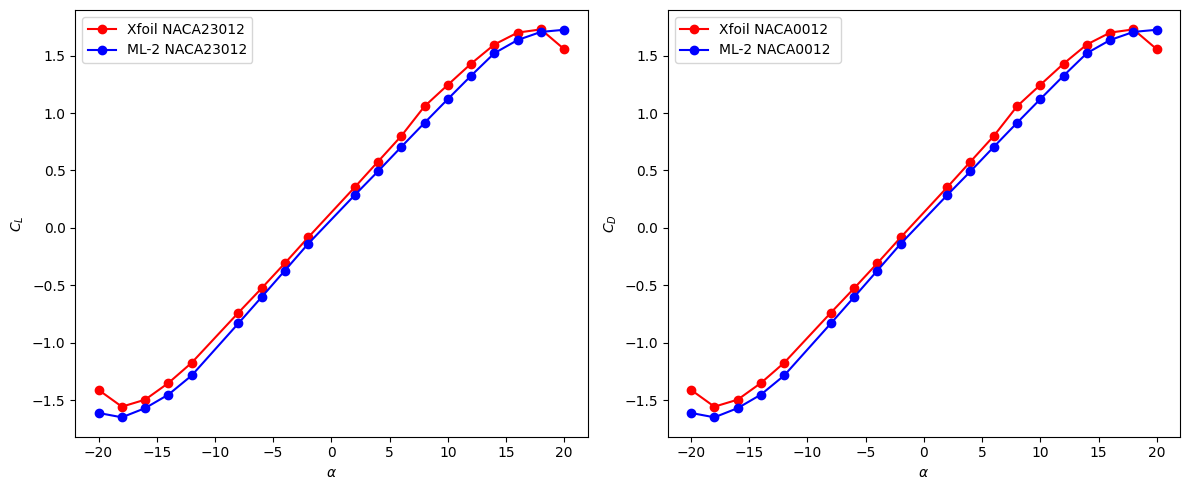

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

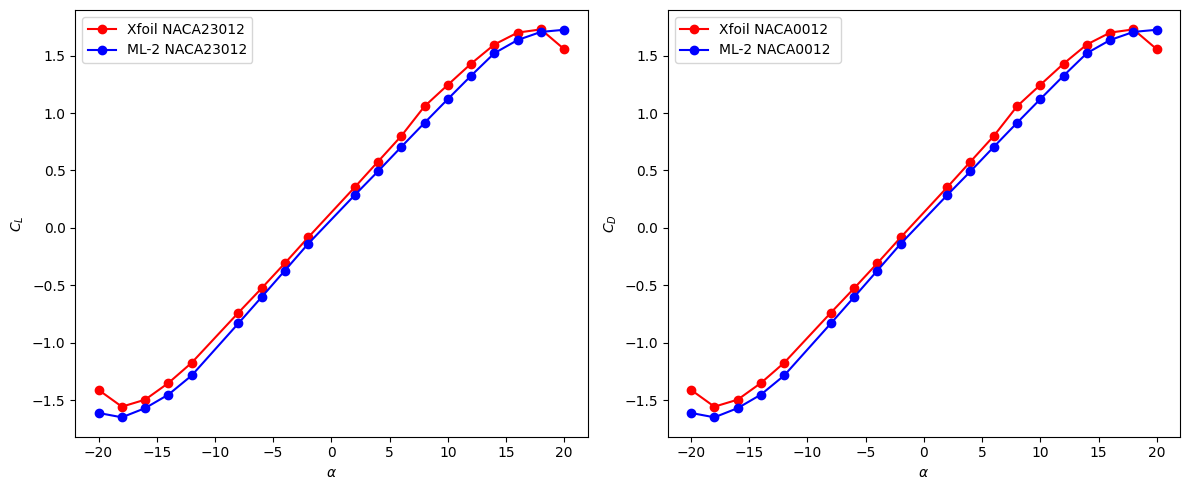

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

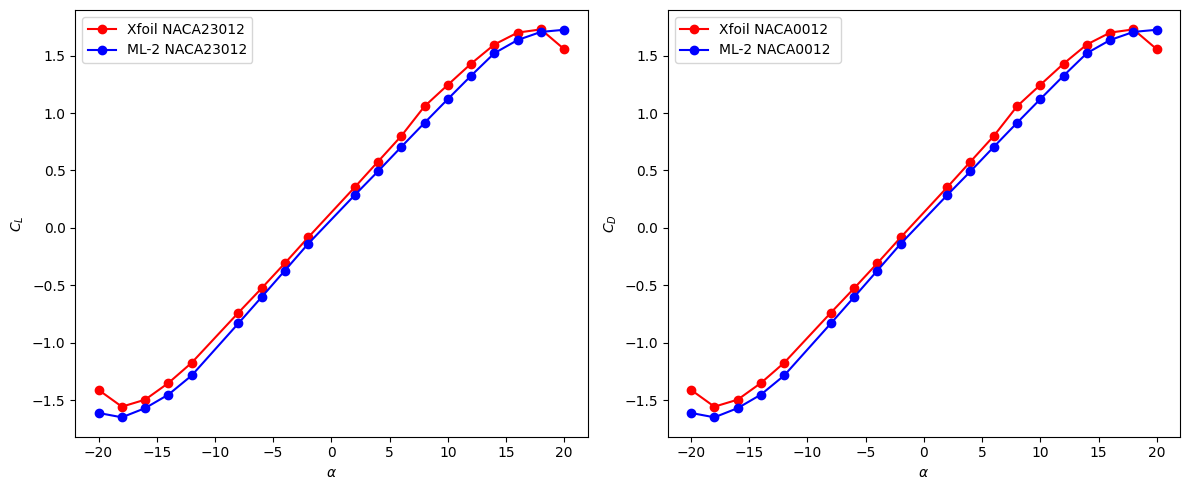

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

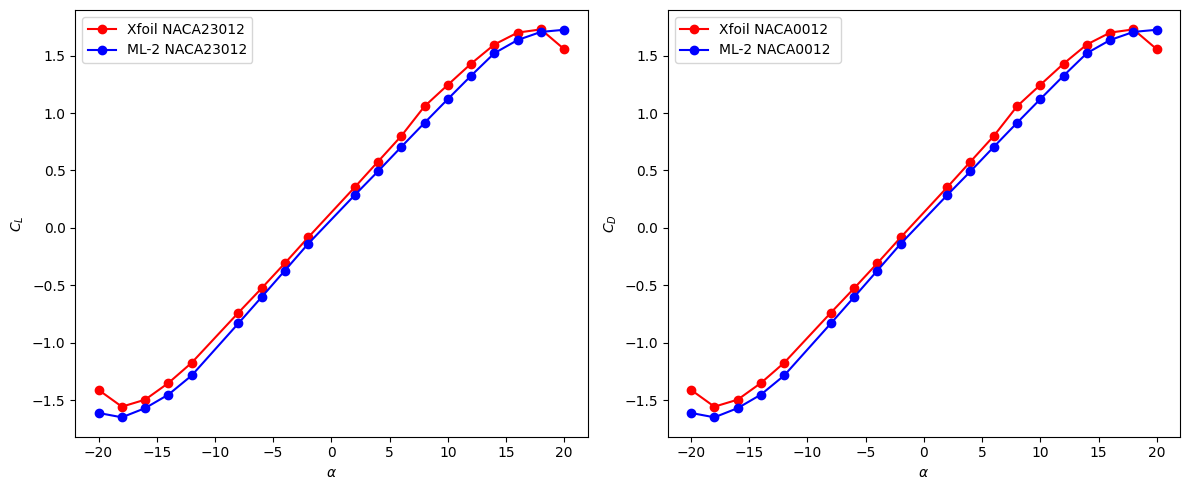

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

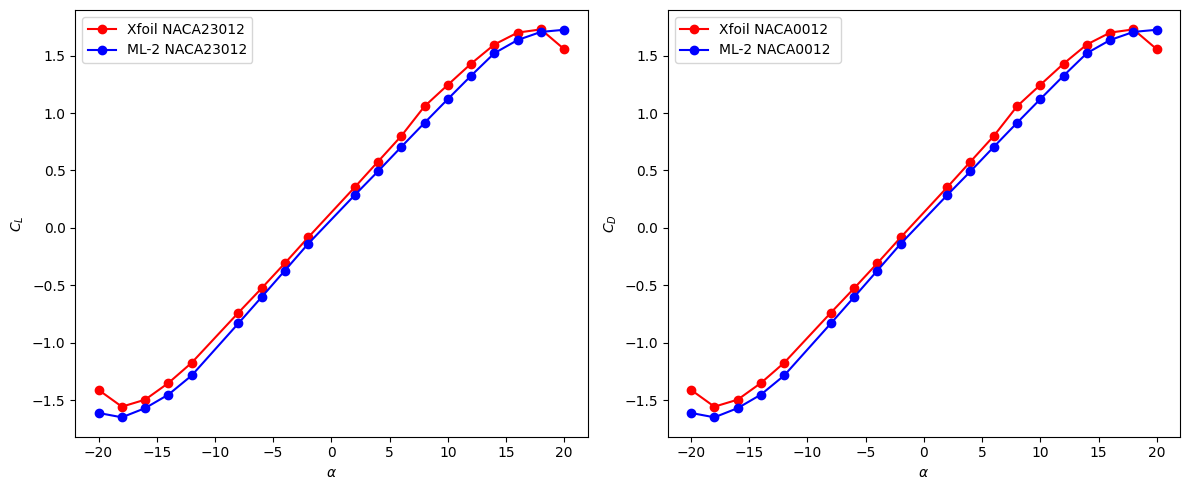

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

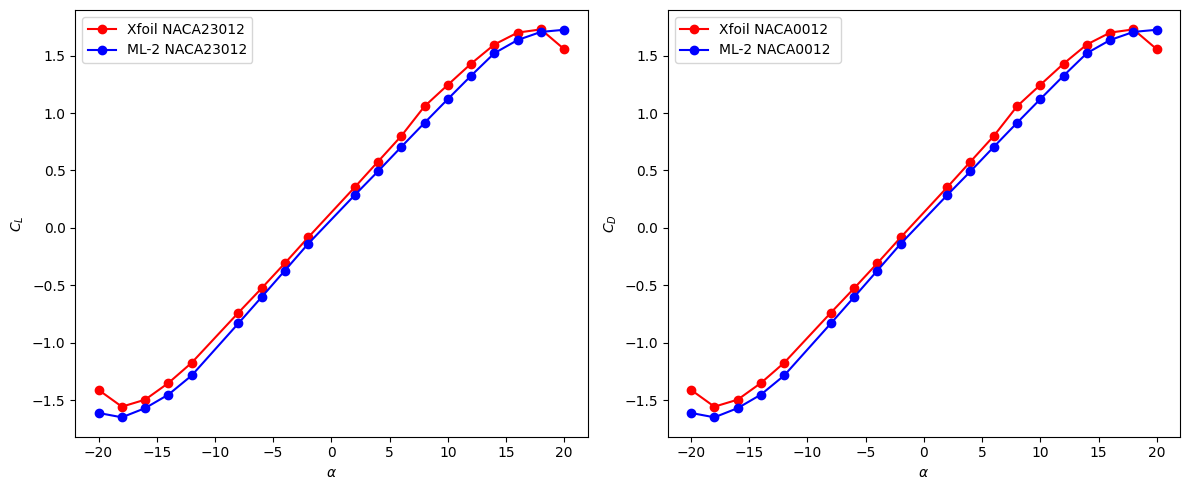

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

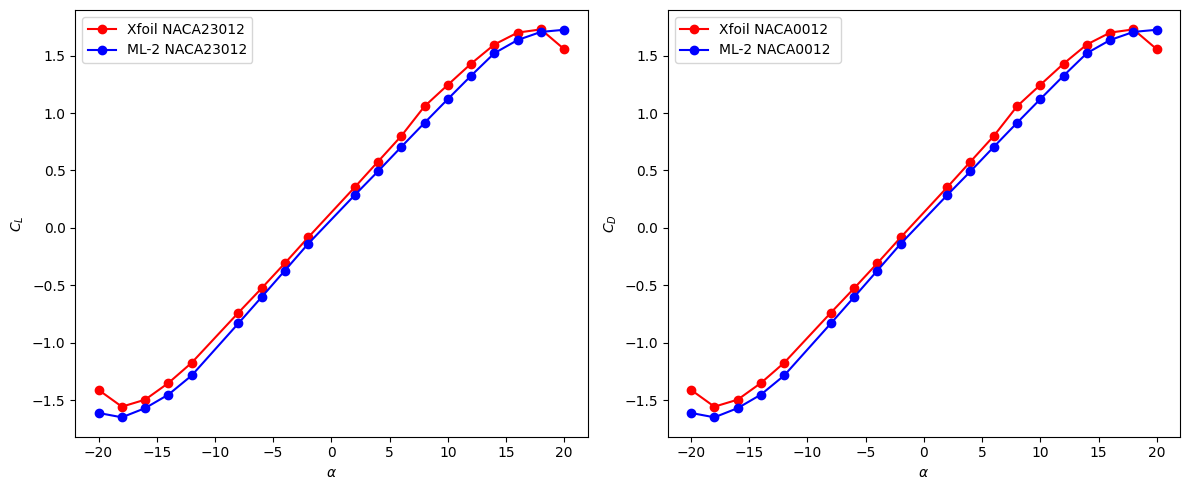

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

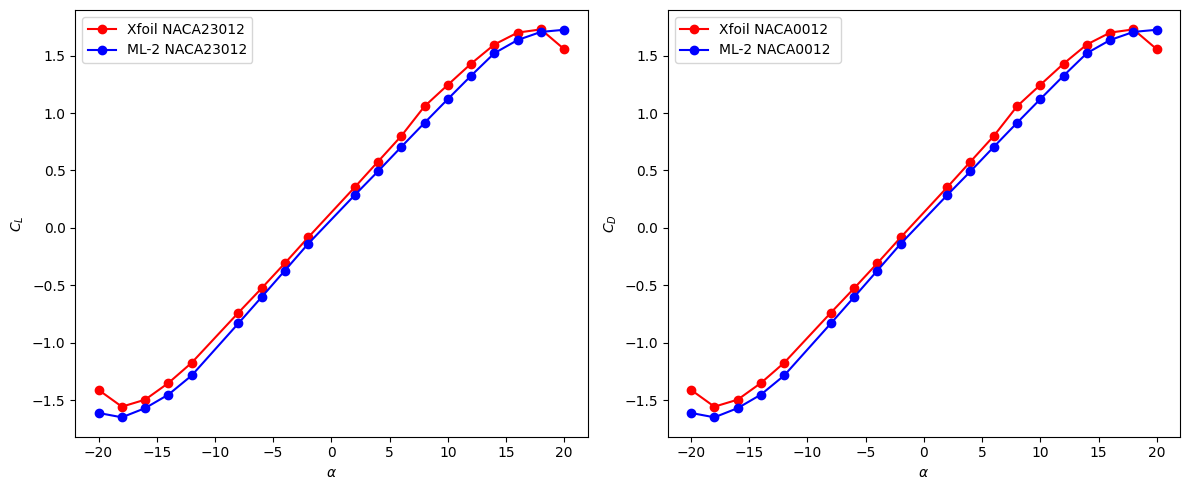

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

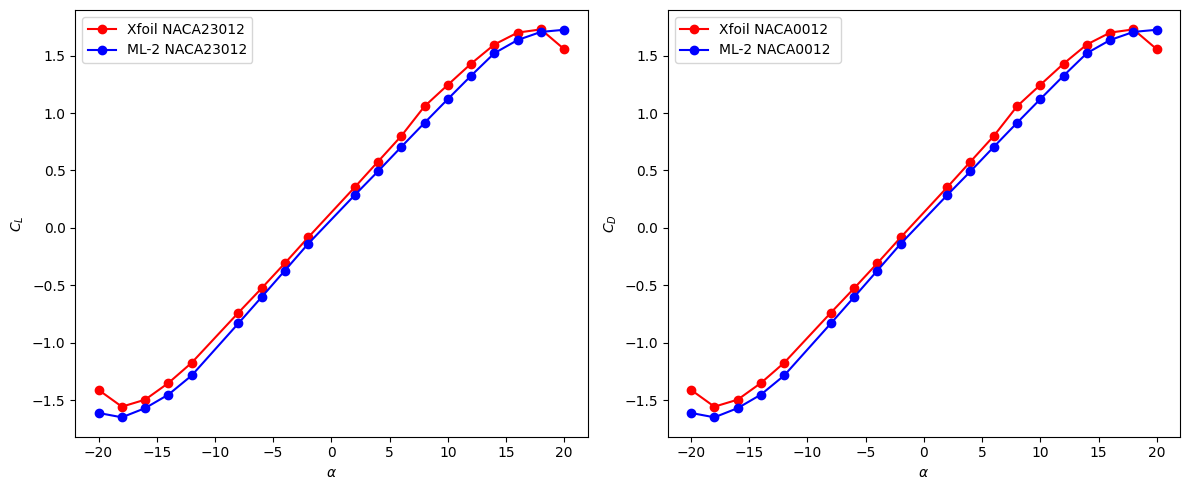

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

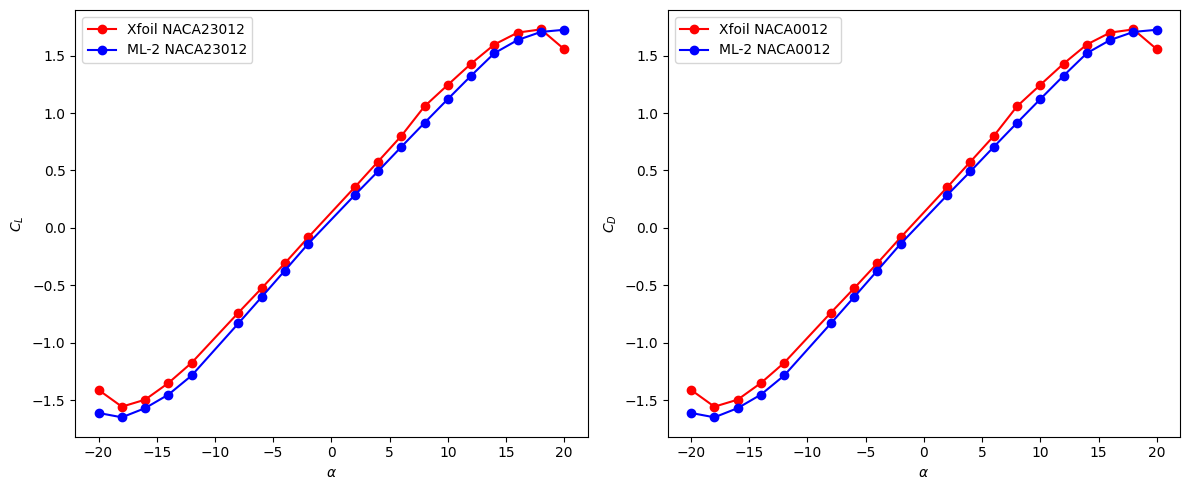

naca23012 CL_test = -1.4104, CL_pred = -1.6109
naca23012 CD_test = -1.4104, CD_pred = -1.6109
naca23012 CL_test = -1.5562, CL_pred = -1.6490
naca23012 CD_test = -1.5562, CD_pred = -1.6490
naca23012 CL_test = -1.4952, CL_pred = -1.5689
naca23012 CD_test = -1.4952, CD_pred = -1.5689
naca23012 CL_test = -1.3500, CL_pred = -1.4511
naca23012 CD_test = -1.3500, CD_pred = -1.4511
naca23012 CL_test = -1.1737, CL_pred = -1.2846
naca23012 CD_test = -1.1737, CD_pred = -1.2846
naca23012 CL_test = -0.7390, CL_pred = -0.8321
naca23012 CD_test = -0.7390, CD_pred = -0.8321
naca23012 CL_test = -0.5259, CL_pred = -0.6027
naca23012 CD_test = -0.5259, CD_pred = -0.6027
naca23012 CL_test = -0.3074, CL_pred = -0.3715
naca23012 CD_test = -0.3074, CD_pred = -0.3715
naca23012 CL_test = -0.0831, CL_pred = -0.1386
naca23012 CD_test = -0.0831, CD_pred = -0.1386
naca23012 CL_test = 0.3537, CL_pred = 0.2855
naca23012 CD_test = 0.3537, CD_pred = 0.2855
naca23012 CL_test = 0.5768, CL_pred = 0.4925
naca23012 CD_test =

In [86]:
# train 30 ensembles of neural network
for i in range(1,31):
    seed_number = int(i*10)
    print(seed_number)
    import random
    random.seed(seed_number)
    from numpy.random import seed
    seed(seed_number)
    tf.random.set_seed(seed_number)
    
    """## Define Neural Network Architecture"""
    n_layers = 2
    n_neurons = [20,20]
    lr = 0.001
    epochs = 10
    batch_size = 16
    
    x1 = Input(shape=(nf1,))
    x2 = Input(shape=(nf2,))
        
    x = Dense(20,activation='relu')(x1)
    x = Dense(20,activation='relu')(x)
    
    # inject physics-based features at some intermediate hidden layes (3rd in this case)
    x = concatenate(inputs=[x, x2])
    
    x = Dense(20,activation='relu')(x)
    x = Dense(20,activation='relu')(x)
    
    output = Dense(nl,activation='linear')(x)
    
    model = Model(inputs=[x1, x2], outputs=output)
    
    print(model.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    """## compile the model"""
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    """## Train the model"""
    
    es = EarlyStopping(monitor='loss', patience=40)
    
    tb = TensorBoard(log_dir='./logs', histogram_freq=10, batch_size=batch_size,
                    write_graph=True, write_images=True, write_grads=True)
    
    history_callback = model.fit(x=[xtrain1, xtrain2], 
                                 y=ytrain, 
                                 batch_size=batch_size, 
                                 epochs=epochs, 
                                 validation_split=0.2, 
                                 shuffle=True, 
                                 callbacks=[tb])
    
    loss = history_callback.history["loss"]
    val_loss = history_callback.history["val_loss"]
    #%%
    plt.figure()
    epochs = range(1, len(loss) + 1)
    plt.semilogy(epochs, loss, 'b', label='Training loss')
    plt.semilogy(epochs, val_loss, 'r', label='Validationloss')
    plt.title('Training and validation loss')
    plt.legend()
    filename = r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\loss_{im}_{seed_number}.png'
    plt.savefig(filename, dpi = 300)
    
    model.save(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\ann_model_{im}_{seed_number}.h5')
    
    tf.compat.v1.reset_default_graph()
    
# predict the CL for NACA 23012 airfoil using all trained nerual networks (i.e., 30 ensembles)
for i in range(1,31):
    seed_number = int(i*10)
    loaded_model = tf.keras.models.load_model(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\ann_model_{im}_{seed_number}.h5')
    
    df = pd.read_csv(r"C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\airfoil_shapes_re_v2\test_data.csv", encoding='utf-8')
    
    df.columns = col_name
    
    df = df[df['CL'].notna()]
    
    df = df[df["Airfoil"] == 'naca23012']
    df = df[df["RE"] == 3e6]
    
    num_samples = df.shape[0]
    
    panel_data_test = np.zeros((num_samples,num_cp+2))
    data_xy_test = np.zeros((num_samples,num_xy,2))
    
    airfoil_names_test = []
    aoa_test = np.zeros(num_samples)
    re_test = np.zeros(num_samples)
    cl_test = np.zeros(num_samples)
    cd_test = np.zeros(num_samples)
    cm_test = np.zeros(num_samples)
    
    airfoils_xcoords_test = df.iloc[:,1:202].values
    airfoils_ycoords_test = df.iloc[:,202:403].values
    
    counter = 0
    cd_scale_factor = 10.0
    
    generate_new_test_data = True
    
    # import data needed for generating test data
    if generate_new_test_data :
        for index, row in df.iterrows():
            airfoil_names_test.append(row.Airfoil)
            aoa_test[counter] = row.AOA2
            re_test[counter] = row.RE
            cl_test[counter] = row.CL
            cd_test[counter] = row.CD*cd_scale_factor
            cm_test[counter] = row.CM
            
            data_xy_test[counter,:,0] = airfoils_xcoords_test[counter,:]
            data_xy_test[counter,:,1] = airfoils_ycoords_test[counter,:]
            
            CL, CDP, Cp, pp = panel(data_xy_test[counter,:,:], alfader=row.AOA2)
            panel_data_test[counter,0], panel_data_test[counter,1], panel_data_test[counter,2:] = CL,CDP,Cp
            
            print(counter, row.Airfoil, row.AOA2)
            counter +=1    
        
        np.savez(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\test_data_re_23012.npz',airfoil_names_test=airfoil_names_test, data_xy_test=data_xy_test,panel_data_test=panel_data_test,aoa_test=aoa_test,re_test=re_test,cl_test=cl_test,cd_test=cd_test,cm_test=cm_test)
    
    else:
        data = np.load(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\test_data_re_23012.npz')
        airfoil_names_test = data['airfoil_names_test']
        data_xy_test = data['data_xy_test']
        panel_data_test = data['panel_data_test']
        aoa_test = data['aoa_test']
        re_test = data['re_test']
        cl_test = data['cl_test']
        cd_test = data['cd_test']
        cm_test = data['cm_test']
    
    # create test data for NACA 23012
    if im == 1:       
        xtest, ytest = training_data(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    elif im == 2:      
        xtest, ytest = training_data_cl_cd(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    elif im == 3:       
        xtest, ytest = training_data_cp(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    elif im == 4:      
        xtest, ytest = training_data_cl(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    
    # scale the test data
    xtest_sc = sc_input.transform(xtest[:,:])  
    xtest_sc1 = np.copy(xtest_sc[:,:2*num_xy]) # airfol shape features
    xtest_sc2 = np.copy(xtest_sc[:,2*num_xy:]) # physics-based features features
    
    # predict the lift coefficient for NACA 23012 airfoil
    ypred_sc = loaded_model.predict([xtest_sc1,xtest_sc2]) 
    ypred = sc_output.inverse_transform(ypred_sc)
    
    fig,ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(aoa_test[:num_samples], ytest[:num_samples,0], 'ro-', label='Xfoil NACA23012')
    ax[0].plot(aoa_test[:num_samples], ypred[:num_samples,0], 'bo-', label=f'ML-{im} NACA23012')
    ax[0].legend()
    
    ax[1].plot(aoa_test[:num_samples], ytest[:num_samples,0], 'ro-', label='Xfoil NACA0012 ')
    ax[1].plot(aoa_test[:num_samples], ypred[:num_samples,0], 'bo-', label=f'ML-{im} NACA0012 ')
    ax[1].legend()
    
    ax[0].set_ylabel(r'$C_L$')
    ax[0].set_xlabel(r'$\alpha$')
    
    ax[1].set_ylabel(r'$C_D$')
    ax[1].set_xlabel(r'$\alpha$')
    
    fig.tight_layout()
    plt.show()
    fig.savefig(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\result_{im}_{seed_number}_23012.png', dpi=300)
    
    np.savez(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\result_{im}_{seed_number}_23012.npz', xtest = xtest, ytest=ytest, ypred=ypred)
    
    file = open(r"C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\output_{im}_{seed_number}_23012.txt", "w", buffering=1)
    
    for i in range(num_samples):
        print(airfoil_names_test[i] + f' CL_test = %.4f, CL_pred = %.4f'%(ytest[i,0], ypred[i,0]))
        print(airfoil_names_test[i] + f' CD_test = %.4f, CD_pred = %.4f'%(ytest[i,0], ypred[i,0]))
        
        print(airfoil_names_test[i] + f' CL_test = %.4f, CL_pred = %.4f'%(ytest[i,0], ypred[i,0]), file=file)
        print(airfoil_names_test[i] + f' CD_test = %.4f, CD_pred = %.4f'%(ytest[i,0], ypred[i,0]), file=file)
    
    file.close()

0 naca23024 -20.0
1 naca23024 -18.0
2 naca23024 -16.0
3 naca23024 -14.0
4 naca23024 -12.0
5 naca23024 -10.0
6 naca23024 -8.0
7 naca23024 -6.0
8 naca23024 -4.0
9 naca23024 -2.0
10 naca23024 0.0
11 naca23024 2.0
12 naca23024 6.0
13 naca23024 8.0
14 naca23024 10.0
15 naca23024 12.0
16 naca23024 14.0
17 naca23024 16.0
18 naca23024 18.0
19 naca23024 20.0


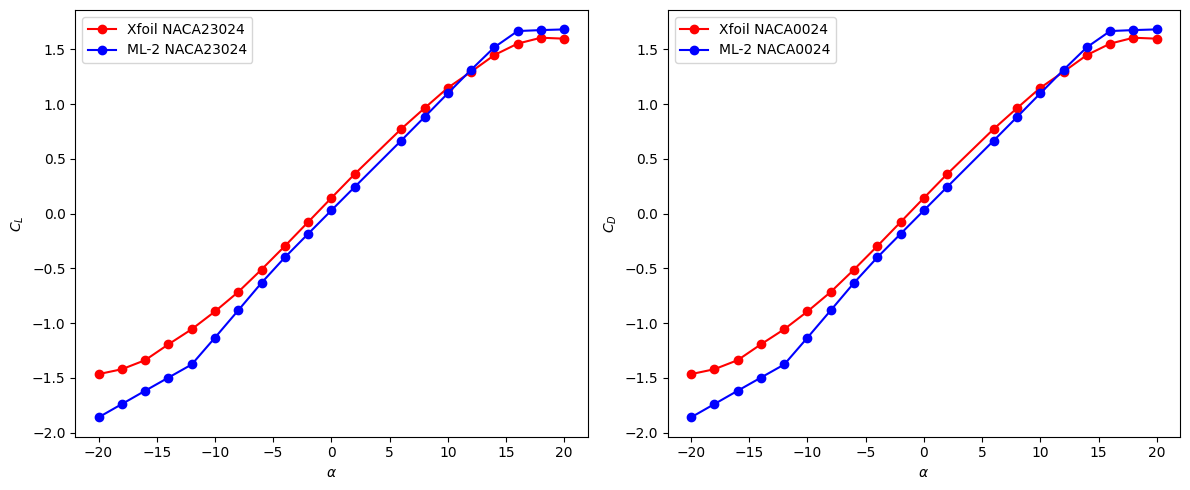

naca23024 CL_test = -1.4665, CL_pred = -1.8613
naca23024 CD_test = -1.4665, CD_pred = -1.8613
naca23024 CL_test = -1.4218, CL_pred = -1.7401
naca23024 CD_test = -1.4218, CD_pred = -1.7401
naca23024 CL_test = -1.3391, CL_pred = -1.6186
naca23024 CD_test = -1.3391, CD_pred = -1.6186
naca23024 CL_test = -1.1944, CL_pred = -1.4984
naca23024 CD_test = -1.1944, CD_pred = -1.4984
naca23024 CL_test = -1.0566, CL_pred = -1.3786
naca23024 CD_test = -1.0566, CD_pred = -1.3786
naca23024 CL_test = -0.8939, CL_pred = -1.1331
naca23024 CD_test = -0.8939, CD_pred = -1.1331
naca23024 CL_test = -0.7156, CL_pred = -0.8836
naca23024 CD_test = -0.7156, CD_pred = -0.8836
naca23024 CL_test = -0.5108, CL_pred = -0.6322
naca23024 CD_test = -0.5108, CD_pred = -0.6322
naca23024 CL_test = -0.2968, CL_pred = -0.4001
naca23024 CD_test = -0.2968, CD_pred = -0.4001
naca23024 CL_test = -0.0773, CL_pred = -0.1848
naca23024 CD_test = -0.0773, CD_pred = -0.1848
naca23024 CL_test = 0.1433, CL_pred = 0.0297
naca23024 CD_te

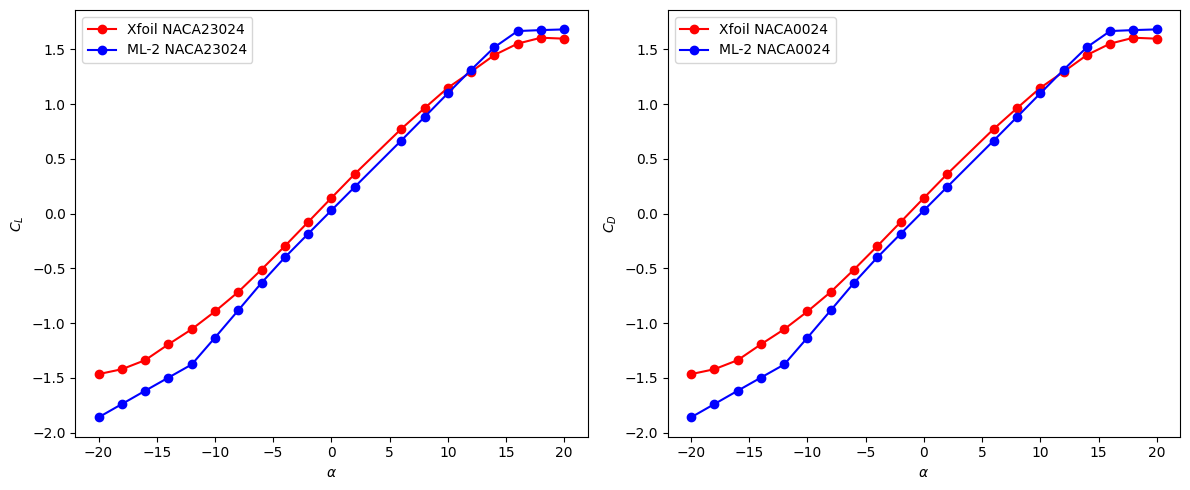

naca23024 CL_test = -1.4665, CL_pred = -1.8613
naca23024 CD_test = -1.4665, CD_pred = -1.8613
naca23024 CL_test = -1.4218, CL_pred = -1.7401
naca23024 CD_test = -1.4218, CD_pred = -1.7401
naca23024 CL_test = -1.3391, CL_pred = -1.6186
naca23024 CD_test = -1.3391, CD_pred = -1.6186
naca23024 CL_test = -1.1944, CL_pred = -1.4984
naca23024 CD_test = -1.1944, CD_pred = -1.4984
naca23024 CL_test = -1.0566, CL_pred = -1.3786
naca23024 CD_test = -1.0566, CD_pred = -1.3786
naca23024 CL_test = -0.8939, CL_pred = -1.1331
naca23024 CD_test = -0.8939, CD_pred = -1.1331
naca23024 CL_test = -0.7156, CL_pred = -0.8836
naca23024 CD_test = -0.7156, CD_pred = -0.8836
naca23024 CL_test = -0.5108, CL_pred = -0.6322
naca23024 CD_test = -0.5108, CD_pred = -0.6322
naca23024 CL_test = -0.2968, CL_pred = -0.4001
naca23024 CD_test = -0.2968, CD_pred = -0.4001
naca23024 CL_test = -0.0773, CL_pred = -0.1848
naca23024 CD_test = -0.0773, CD_pred = -0.1848
naca23024 CL_test = 0.1433, CL_pred = 0.0297
naca23024 CD_te

In [87]:

# predict the CL for NACA 23024 airfoil using all trained nerual networks (i.e., 30 ensembles)
for i in range(1,3):
    seed_number = int(i*10)
    loaded_model = tf.keras.models.load_model(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\ann_model_{im}_{seed_number}.h5')
        
    data_path = '../airfoil_shapes_re_v2/'   
    
    db = data_path + ''
    df = pd.read_csv(r"C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\airfoil_shapes_re_v2\test_data.csv", encoding='utf-8')
    
    df.columns = col_name
    
    df = df[df['CL'].notna()]
    
    df = df[df["Airfoil"] == 'naca23024']
    df = df[df["RE"] == 3e6]
    
    num_samples = df.shape[0]
    
    panel_data_test = np.zeros((num_samples,num_cp+2))
    data_xy_test = np.zeros((num_samples,num_xy,2))
    
    airfoil_names_test = []
    aoa_test = np.zeros(num_samples)
    re_test = np.zeros(num_samples)
    cl_test = np.zeros(num_samples)
    cd_test = np.zeros(num_samples)
    cm_test = np.zeros(num_samples)
    
    airfoils_xcoords_test = df.iloc[:,1:202].values
    airfoils_ycoords_test = df.iloc[:,202:403].values
    
    counter = 0
    cd_scale_factor = 10.0
    
    generate_new_test_data = True
    
    # import data needed for generating test data
    if generate_new_test_data :
        for index, row in df.iterrows():
            airfoil_names_test.append(row.Airfoil)
            aoa_test[counter] = row.AOA2
            re_test[counter] = row.RE
            cl_test[counter] = row.CL
            cd_test[counter] = row.CD*cd_scale_factor
            cm_test[counter] = row.CM
            
            data_xy_test[counter,:,0] = airfoils_xcoords_test[counter,:]
            data_xy_test[counter,:,1] = airfoils_ycoords_test[counter,:]
            
            CL, CDP, Cp, pp = panel(data_xy_test[counter,:,:], alfader=row.AOA2)
            panel_data_test[counter,0], panel_data_test[counter,1], panel_data_test[counter,2:] = CL,CDP,Cp
            
            print(counter, row.Airfoil, row.AOA2)
            counter +=1    
        
        np.savez(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\test_data_re_23024.npz',airfoil_names_test=airfoil_names_test, data_xy_test=data_xy_test,panel_data_test=panel_data_test,aoa_test=aoa_test,re_test=re_test,cl_test=cl_test,cd_test=cd_test,cm_test=cm_test)
    
    else:
        data = np.load(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\test_data_re_23024.npz')
        airfoil_names_test = data['airfoil_names_test']
        data_xy_test = data['data_xy_test']
        panel_data_test = data['panel_data_test']
        aoa_test = data['aoa_test']
        re_test = data['re_test']
        cl_test = data['cl_test']
        cd_test = data['cd_test']
        cm_test = data['cm_test']
    
    # create test data for NACA 23012
    if im == 1:       
        xtest, ytest = training_data(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    elif im == 2:      
        xtest, ytest = training_data_cl_cd(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    elif im == 3:       
        xtest, ytest = training_data_cp(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    elif im == 4:      
        xtest, ytest = training_data_cl(data_xy_test,panel_data_test,aoa_test,re_test,cl_test,cd_test)
    
    # scale the test data
    xtest_sc = sc_input.transform(xtest[:,:])  
    xtest_sc1 = np.copy(xtest_sc[:,:2*num_xy]) # airfol shape features
    xtest_sc2 = np.copy(xtest_sc[:,2*num_xy:]) # physics-based features features
    
    # predict the lift coefficient for NACA 23024 airfoil
    ypred_sc = loaded_model.predict([xtest_sc1,xtest_sc2]) 
    ypred = sc_output.inverse_transform(ypred_sc)
    
    fig,ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(aoa_test[:num_samples], ytest[:num_samples,0], 'ro-', label='Xfoil NACA23024')
    ax[0].plot(aoa_test[:num_samples], ypred[:num_samples,0], 'bo-', label=f'ML-{im} NACA23024')
    ax[0].legend()
    
    ax[1].plot(aoa_test[:num_samples], ytest[:num_samples,0], 'ro-', label='Xfoil NACA0024')
    ax[1].plot(aoa_test[:num_samples], ypred[:num_samples,0], 'bo-', label=f'ML-{im} NACA0024')
    ax[1].legend()
    
    ax[0].set_ylabel(r'$C_L$')
    ax[0].set_xlabel(r'$\alpha$')
    
    ax[1].set_ylabel(r'$C_D$')
    ax[1].set_xlabel(r'$\alpha$')
    
    fig.tight_layout()
    plt.show()
    fig.savefig(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\result_{im}_{seed_number}_23024.png', dpi=300)
    
    np.savez(r'C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\result_{im}_{seed_number}_23024.npz', xtest = xtest, ytest=ytest, ypred=ypred)
    
    file = open(r"C:\Users\emjan\Documents\GitHub\Dissertation_Workspace\Codes\Neural Networks PyTorch\Code Sources From Papers\PGML main\PGML main\results\output_{im}_{seed_number}_23024.txt", "w", buffering=1)
    
    for i in range(num_samples):
        print(airfoil_names_test[i] + f' CL_test = %.4f, CL_pred = %.4f'%(ytest[i,0], ypred[i,0]))
        print(airfoil_names_test[i] + f' CD_test = %.4f, CD_pred = %.4f'%(ytest[i,0], ypred[i,0]))
        
        print(airfoil_names_test[i] + f' CL_test = %.4f, CL_pred = %.4f'%(ytest[i,0], ypred[i,0]), file=file)
        print(airfoil_names_test[i] + f' CD_test = %.4f, CD_pred = %.4f'%(ytest[i,0], ypred[i,0]), file=file)
    
    file.close()